<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Regression and Classification to Predict House Prices

## 02. Modelling

<br/><br/>

This project was completed during my Data Science Immersive bootcamp at General Assembly in London.

The project scenario required acting as a new "full stack" real estate company, which strategy is two-fold:

- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

This imaginary company is still small, and although investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses.
The company is based in Ames, Iowa, and has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames Housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) made available on Kaggle.  

<br/><br/>


**Goals:**
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

This way, the company can use this information to purhcase homes that are likely to sell for more than the purchase cost plus the renovation cost.



<br/><br/>

---

The modelling phase is composed by four parts:   
- Part A, whose goal is to estimate house values based on fixed characteristics  
- Part B, whose goal is to estimate house values based on changeable characteristics
- Part C, whose goal is to estimate house values based on changeable characteristics unexplained by the fixed ones
- Part D, whose goal is to determine which property features predict an "abnormal" sale

Part A, B and C are regression problems, while Part D is a classification problem.  


<br/><br/>

## Libraries Import  

<br/><br/>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=1)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [5]:
# run to avoid warnings
import warnings
warnings.filterwarnings('ignore')

## Modelling  

<br/><br/>

In [6]:
# retrieve information about variable types
continuous_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                   '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                   'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'TotalSFAbvGrd', 'TotalSF',
                   'LotOpenArea', 'FloorAreaRatio', 'TotalBath', 'SalePrice']

discrete_vars = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'Age']

ordinal_vars = ['OverallQual', 'OverallCond', 'CentralAir', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'LandSlope',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'PavedDrive', 'Fence']

nominal_vars = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
                'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature',
                'SaleType', 'SaleCondition']

In [7]:
# define quantitative and categorical variables
quant_vars = continuous_vars + discrete_vars
categ_vars = ordinal_vars + nominal_vars
price = ['SalePrice']

## *A. Estimating house prices based on fixed characteristics*   

For this regression problem will be implemented four different models:
- Linear Regression (without regularisation)
- Lasso Regression with LassoCV
- Ridge Regression with RidgeCV
- Elastic Net Regression with ElasticNetCV

Models will be trained on pre-2010 data, and their performance evaluated on the 2010 data.  

<br/><br/>

In [8]:
# load the data
df_f = pd.read_csv('datasets/house_03_fixed_optimised.csv')

In [9]:
# dummify categorical variables
df_f_dum = pd.get_dummies(df_f, columns=[x for x in df_f.columns if x in nominal_vars], drop_first=True)

In [10]:
df_f_dum.head()

LotFrontage  LotArea  LandSlope  YearRemodAdd  BsmtExposure  KitchenAbvGr  \
0         65.0   8450.0          3        2003.0             1             1   
1         80.0   9600.0          3        1976.0             4             1   
2         68.0  11250.0          3        2002.0             2             1   
3         60.0   9550.0          3        1970.0             1             1   
4         84.0  14260.0          3        2000.0             3             1   

   Fireplaces  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0           0         548           0           61              0          0   
1           1         460         298            0              0          0   
2           1         608           0           42              0          0   
3           1         642           0           35            272          0   
4           1         836         192           84              0          0   

   ScreenPorch  MiscVal  MoSold  YrSold  SalePrice  TotalSF  FloorAreaRatio  \
0            0        0       2    2008     208500   2566.0        0.202367   
1            0        0       5    2007     181500   2524.0        0.131458   
2            0        0       9    2008     223500   2706.0        0.158756   
3            0        0       2    2006     140000   2473.0        0.179791   
4            0        0      12    2008     250000   3343.0        0.154137   

   TotalBath  Age  MSZoning_RH  MSZoning_RL  MSZoning_RM  LotShape_IR2  \
0        3.5    5            0            1            0             0   
1        2.5   31            0            1            0             0   
2        3.5    7            0            1            0             0   
3        2.0   91            0            1            0             0   
4        3.5    8            0            1            0             0   

   LotShape_IR3  LotShape_Reg  LandContour_HLS  LandContour_Low  \
0             0             1                0                0   
1             0             1                0                0   
2             0             0                0                0   
3             0             0                0                0   
4             0             0                0                0   

   LandContour_Lvl  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  \
0                1                  0              0              0   
1                1                  0              1              0   
2                1                  0              0              0   
3                1                  0              0              0   
4                1                  0              1              0   

   LotConfig_Inside  Neighborhood_Blueste  Neighborhood_BrDale  \
0                 1                     0                    0   
1                 0                     0                    0   
2                 1                     0                    0   
3                 0                     0                    0   
4                 0                     0                    0   

   Neighborhood_BrkSide  Neighborhood_ClearCr  Neighborhood_CollgCr  \
0                     0                     0                     1   
1                     0                     0                     0   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     0   

   Neighborhood_Crawfor  Neighborhood_Edwards  Neighborhood_Gilbert  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     1                     0                     0   
4                     0                     0                     0   

   Neighborhood_IDOTRR  Neighborhood_Mea

In [11]:
# check the proportion of houses per year sold
df_f['YrSold'].value_counts(normalize = True)

2009    0.231327
2007    0.225526
2006    0.215373
2008    0.208122
2010    0.119652
Name: YrSold, dtype: float64

In [12]:
# create a train-test split based on YrSold (pre-2010 is train, 2010 is test)
X_train = df_f_dum[df_f_dum['YrSold'] < 2010].copy()
X_test = df_f_dum[df_f_dum['YrSold'] == 2010].copy()

y_train = X_train.pop('SalePrice')
y_test = X_test.pop('SalePrice')

In [13]:
# check the shape of the modelling sets
print('Training set shape')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('')
print('Test set shape')
print('X:', X_test.shape)
print('y:', y_test.shape)

Training set shape
X: (1214, 105)
y: (1214,)

Test set shape
X: (165, 105)
y: (165,)


In [14]:
# select quantitative features which still are in the dataframe
quant_cols = [x for x in X_train.columns if x in quant_vars]

# rescale the numerical values in train and test sets
scaler = StandardScaler()
X_train[quant_cols] = scaler.fit_transform(X_train[quant_cols])
X_test[quant_cols] = scaler.transform(X_test[quant_cols])

### Linear Regression (without regularisation)

In [15]:
# instantiate the model
linreg = LinearRegression()

# fit the model
linreg.fit(X_train, y_train)

# calculate the scores
a_linreg_train = linreg.score(X_train, y_train)
a_linreg_test = linreg.score(X_test, y_test)
a_linreg_cv = (cross_val_score(linreg, X_train, y_train, cv = 10)).mean()

a_linreg_predictions_train = linreg.predict(X_train)
a_linreg_predictions = linreg.predict(X_test)

a_linreg_MSE = metrics.mean_squared_error(y_test, a_linreg_predictions)
a_linreg_MAE = metrics.mean_absolute_error(y_test, a_linreg_predictions)

# residual_train = y_train - predicted_train
# residual_2 = y_test - predicted

# collect the scores in a dataframe to compare different models later
a_linreg_df = pd.DataFrame([{'train': a_linreg_train,
                             'test' : a_linreg_test,
                             'CV'   : a_linreg_cv,
                             'MSE'  : a_linreg_MSE,
                             'MAE'  : a_linreg_MAE}],
                             index = ['A. Linear Regression'])

# score the model
print('A. Linear Regression Scores: \n')
print('R-squared train score: ', a_linreg_train)
print('R-squared test score:  ', a_linreg_test)
print('R-squared CV score:    ', a_linreg_cv)
print('Mean Squared Error:    ', a_linreg_MSE)
print('Mean Absolute Error:   ', a_linreg_MAE)

A. Linear Regression Scores: 

R-squared train score:  0.844353441135504
R-squared test score:   -5.3405673784158436e+23
R-squared CV score:     -2.351305420592307e+23
Mean Squared Error:     1.854422493929631e+33
Mean Absolute Error:    3352450477747740.5


In [16]:
# display the model intercept
print('Intercept:', linreg.intercept_)

Intercept: 165548.88292833607


In [17]:
# collect the model coefficients in a dataframe
linreg_coef = pd.DataFrame(list(zip(X_train.columns, linreg.coef_)), columns = ['variable','coefficient'])
linreg_coef['coef_abs'] = abs(linreg_coef['coefficient'])

# display the largest model coefficients
linreg_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable   coefficient      coef_abs
86        RoofStyle_Shed  5.531543e+17  5.531543e+17
68       Condition2_RRAe -5.531543e+17  5.531543e+17
67       Condition2_PosA  1.184579e+05  1.184579e+05
93          SaleType_Con  8.076758e+04  8.076758e+04
58       Condition1_Norm  8.025778e+04  8.025778e+04
65       Condition2_None -6.787823e+04  6.787823e+04
73        BldgType_Twnhs -3.325101e+04  3.325101e+04
92          SaleType_CWD  3.215346e+04  3.215346e+04
39  Neighborhood_Edwards -3.165705e+04  3.165705e+04
54  Neighborhood_StoneBr  3.094570e+04  3.094570e+04
48  Neighborhood_NridgHt  2.971836e+04  2.971836e+04
43  Neighborhood_Mitchel -2.895525e+04  2.895525e+04
24          LotShape_IR3 -2.771045e+04  2.771045e+04
47  Neighborhood_NoRidge  2.651097e+04  2.651097e+04
51   Neighborhood_Sawyer -2.595798e+04  2.595798e+04
40  Neighborhood_Gilbert -2.535373e+04  2.535373e+04
74       BldgType_TwnhsE -2.481556e+04  2.481556e+04
49  Neighborhood_OldTown -2.374955e+04  2.374955e+04
64       Condition1_RRNn  2.328052e+04  2.328052e+04
41   Neighborhood_IDOTRR -2.281703e+04  2.281703e+04

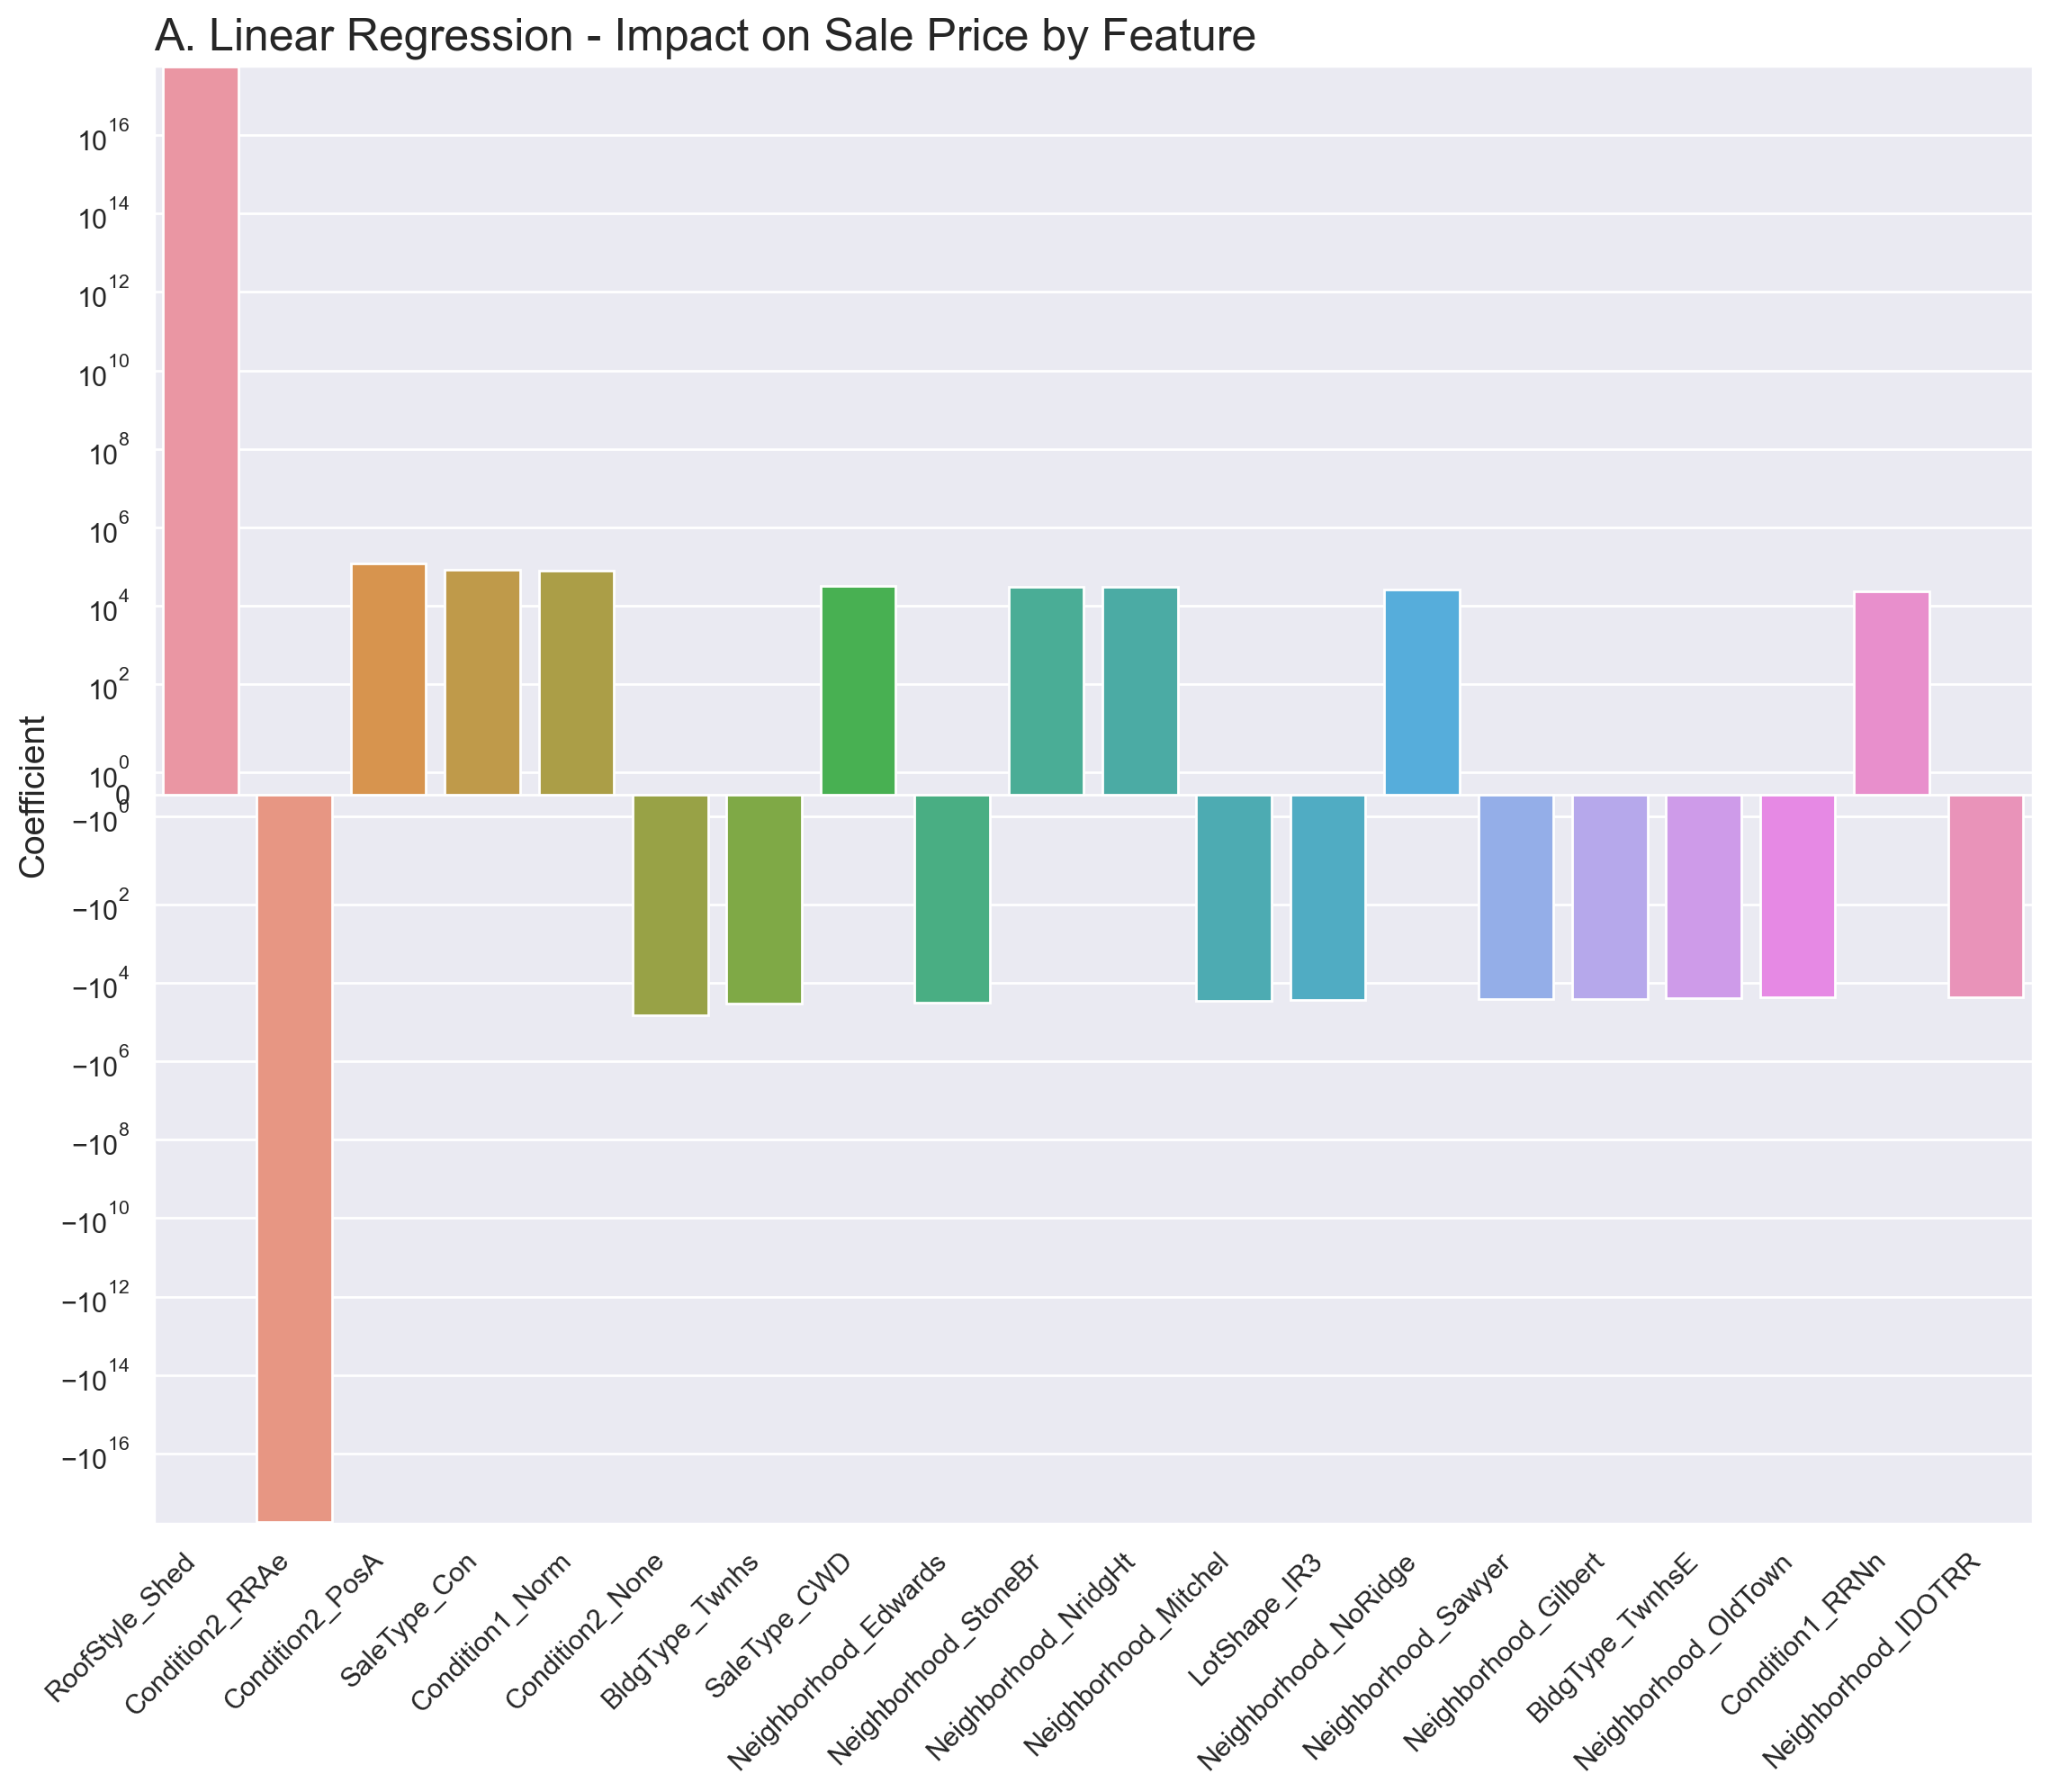

In [18]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,10))

sns.barplot(data=linreg_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('A. Linear Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.yscale('symlog')

plt.show()

### Lasso Regression with LassoCV

In [19]:
# instantiate a LassoCV model
opt_lasso = LassoCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_lasso.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_lasso.alpha_)

Optimal Alpha: 108.43659686896109


In [20]:
# instantiate the model
lasso = Lasso(alpha=opt_lasso.alpha_)

# fit the model
lasso.fit(X_train, y_train)

# calculate the scores
a_lasso_train = lasso.score(X_train, y_train)
a_lasso_test = lasso.score(X_test, y_test)
a_lasso_cv = (cross_val_score(lasso, X_train, y_train, cv = 10)).mean()

a_lasso_predictions_train = lasso.predict(X_train)
a_lasso_predictions = lasso.predict(X_test)

a_lasso_MSE = metrics.mean_squared_error(y_test, a_lasso_predictions)
a_lasso_MAE = metrics.mean_absolute_error(y_test, a_lasso_predictions)

# collect the scores in a dataframe to compare different models later
a_lasso_df = pd.DataFrame([{'train': a_lasso_train,
                            'test' : a_lasso_test,
                            'CV'   : a_lasso_cv,
                            'MSE'  : a_lasso_MSE,
                            'MAE'  : a_lasso_MAE}],
                            index = ['A. Lasso Regression'])

# score the model
print('A. Lasso Regression Scores: \n')
print('R-squared train score: ', a_lasso_train)
print('R-squared test score:  ', a_lasso_test)
print('R-squared CV score:    ', a_lasso_cv)
print('Mean Squared Error:    ', a_lasso_MSE)
print('Mean Absolute Error:   ', a_lasso_MAE)

A. Lasso Regression Scores: 

R-squared train score:  0.8263956355012392
R-squared test score:   0.8515969675101209
R-squared CV score:     0.7693202198396144
Mean Squared Error:     515304652.3274721
Mean Absolute Error:    16737.20356691819


In [21]:
# display the model intercept
print('Intercept:', lasso.intercept_)

Intercept: 166819.2350155963


In [22]:
# collect the model coefficients in a dataframe
lasso_coef = pd.DataFrame(list(zip(X_train.columns, lasso.coef_)), columns = ['variable','coefficient'])
lasso_coef['coef_abs'] = abs(lasso_coef['coefficient'])

# display the largest model coefficients
lasso_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable   coefficient      coef_abs
48  Neighborhood_NridgHt  34567.608110  34567.608110
47  Neighborhood_NoRidge  33235.122888  33235.122888
54  Neighborhood_StoneBr  27276.677170  27276.677170
38  Neighborhood_Crawfor  23595.616549  23595.616549
73        BldgType_Twnhs -21510.508453  21510.508453
53  Neighborhood_Somerst  21243.449915  21243.449915
24          LotShape_IR3 -17249.293777  17249.293777
16               TotalSF  17224.955176  17224.955176
39  Neighborhood_Edwards -15630.662695  15630.662695
74       BldgType_TwnhsE -13492.533385  13492.533385
43  Neighborhood_Mitchel -12648.988820  12648.988820
56  Neighborhood_Veenker   9762.224804   9762.224804
51   Neighborhood_Sawyer  -9280.163765   9280.163765
3           YearRemodAdd   8834.185057   8834.185057
55   Neighborhood_Timber   8575.443364   8575.443364
29     LotConfig_CulDSac   7913.850710   7913.850710
18             TotalBath   7860.307552   7860.307552
19                   Age  -7726.204716   7726.204716
40  Neighborhood_Gilbert  -7591.079665   7591.079665
82       RoofStyle_Gable  -7134.067701   7134.067701

In [23]:
# display the coefficients which has been reduced to 0
lasso_zeroed = lasso_coef[lasso_coef['coefficient'] == 0].shape[0]
print('Lasso Regression has zeroed',lasso_zeroed , 'coefficients.')
list(lasso_coef['variable'][lasso_coef['coefficient'] == 0].values)

Lasso Regression has zeroed 50 coefficients.


['LotFrontage',
 'LandSlope',
 'MiscVal',
 'MSZoning_RH',
 'LotShape_IR2',
 'LandContour_Low',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_ClearCr',
 'Neighborhood_IDOTRR',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_SWISU',
 'Neighborhood_SawyerW',
 'Condition1_PosA',
 'Condition1_PosN',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_None',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'BldgType_2fmCon',
 'BldgType_Duplex',
 'HouseStyle_1.5Unf',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'HouseStyle_2Story',
 'RoofStyle_Gambrel',
 'RoofStyle_Hip',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'Foundation_Stone',
 'Foundation_Wood',
 'SaleType_CWD',
 'SaleType_Con',
 'SaleType_ConLD',
 'SaleType_ConLI',
 'SaleType_ConLw',
 'SaleType_Oth',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family

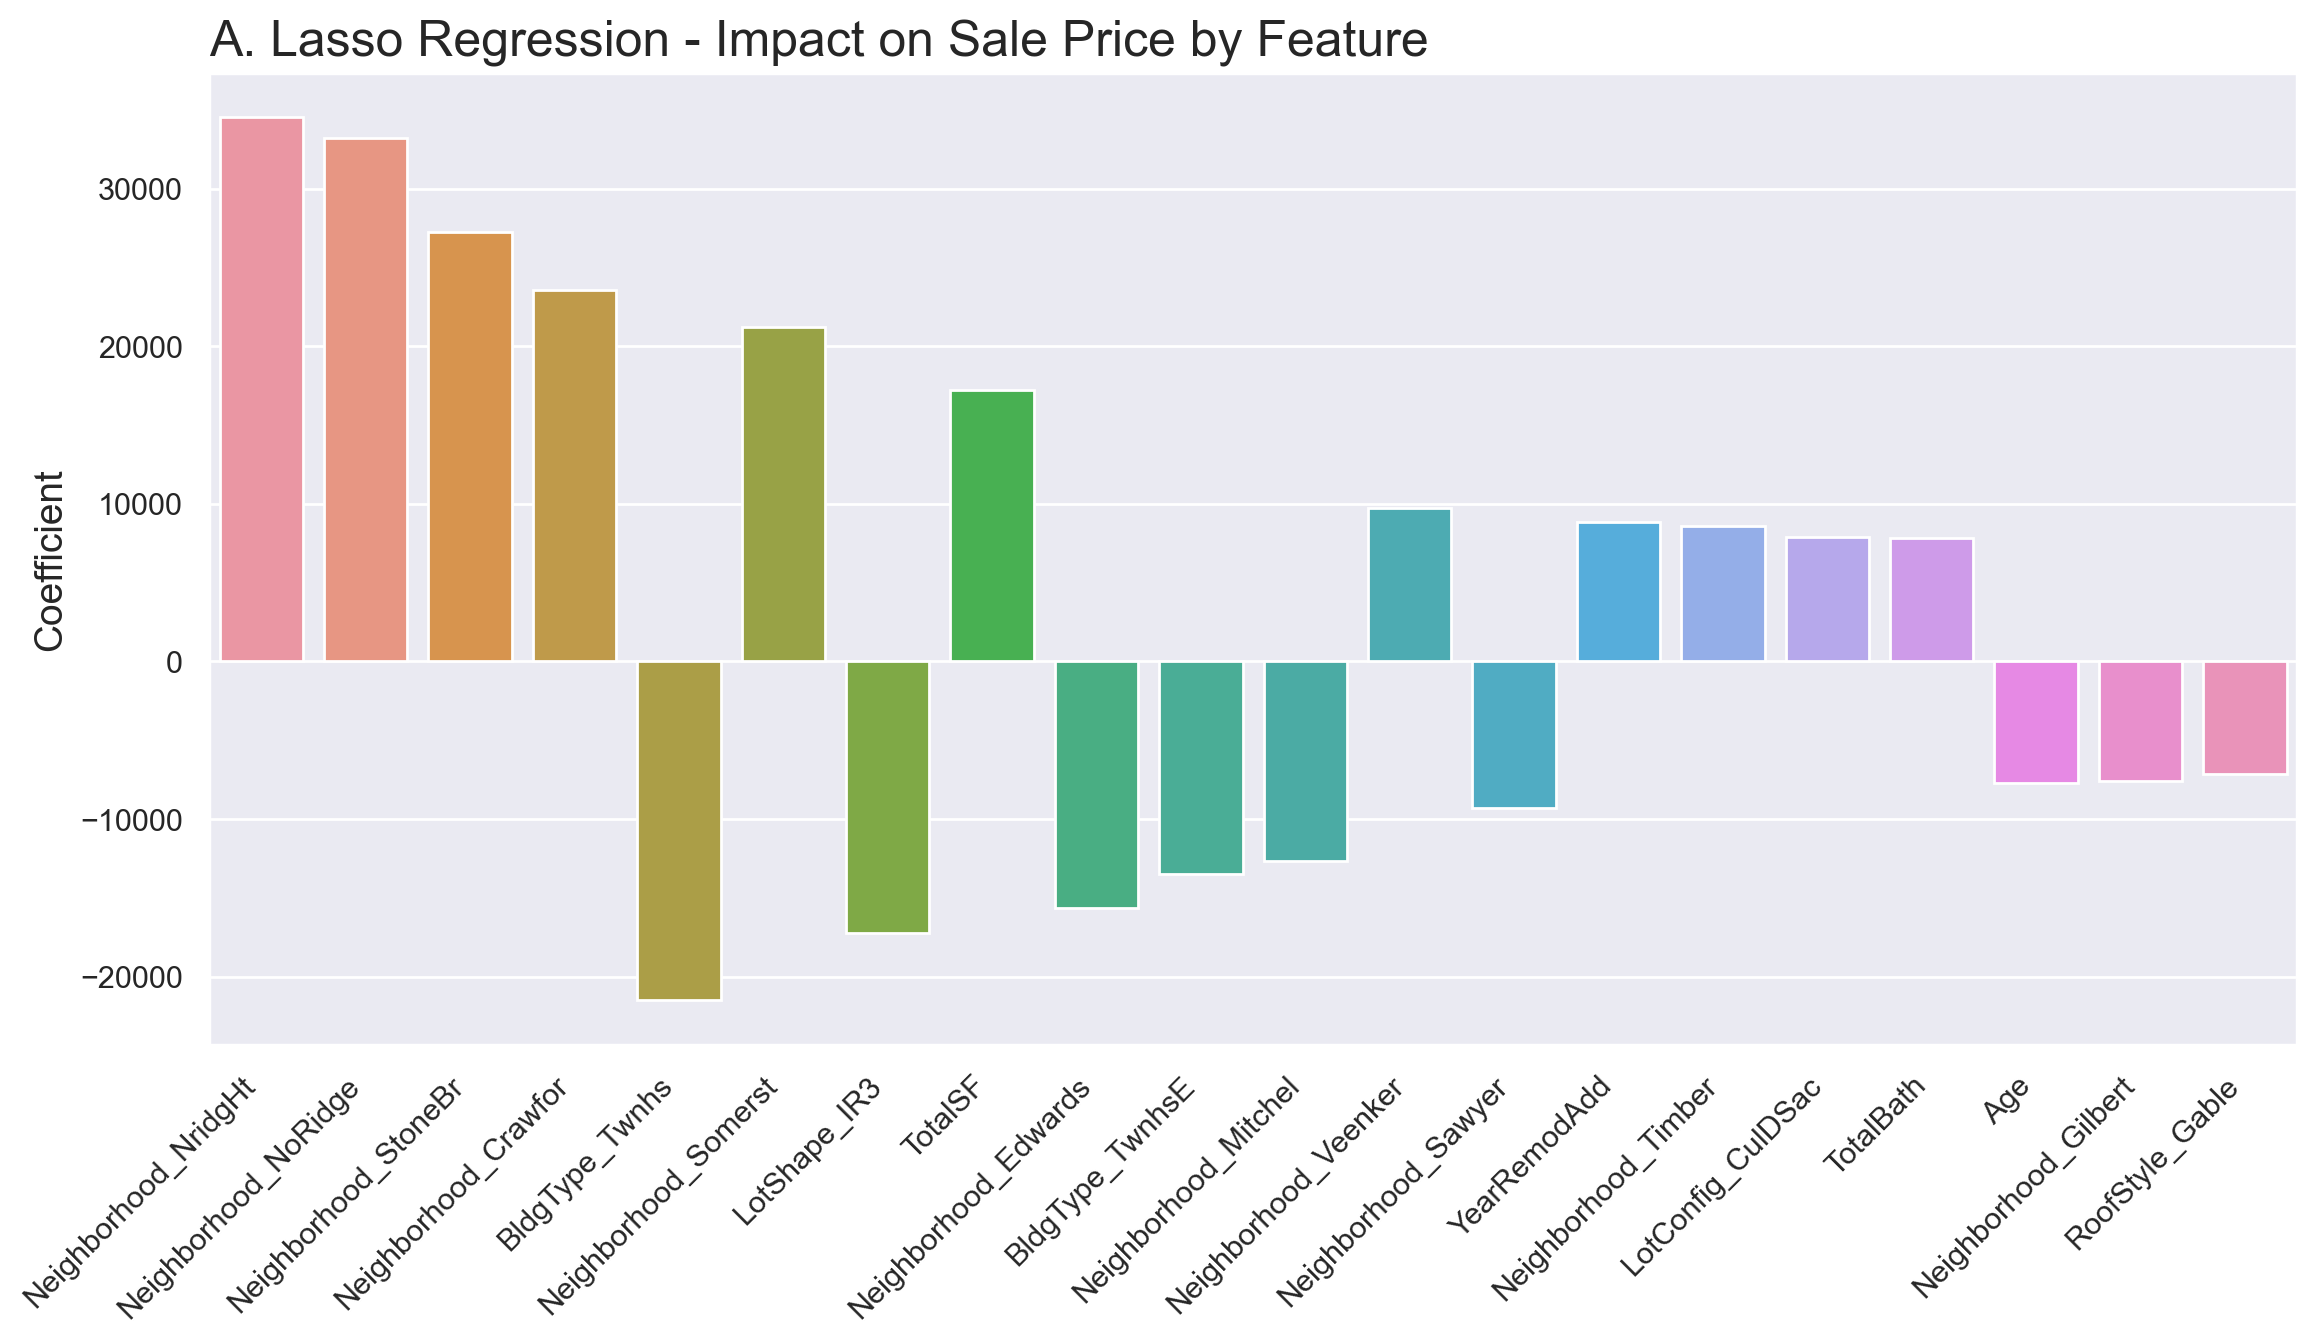

In [24]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=lasso_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('A. Lasso Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Ridge Regression with RidgeCV

In [25]:
# instantiate a RidgeCV model
opt_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_ridge.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_ridge.alpha_)

Optimal Alpha: 7.575250258771915


In [26]:
# instantiate the model
ridge = Ridge(alpha=opt_ridge.alpha_)

# fit the model
ridge.fit(X_train, y_train)

# calculate the scores
a_ridge_train = ridge.score(X_train, y_train)
a_ridge_test = ridge.score(X_test, y_test)
a_ridge_cv = (cross_val_score(ridge, X_train, y_train, cv = 10)).mean()

a_ridge_predictions_train = ridge.predict(X_train)
a_ridge_predictions = ridge.predict(X_test)

a_ridge_MSE = metrics.mean_squared_error(y_test, a_ridge_predictions)
a_ridge_MAE = metrics.mean_absolute_error(y_test, a_ridge_predictions)

# collect the scores in a dataframe to compare different models later
a_ridge_df = pd.DataFrame([{'train': a_ridge_train,
                            'test' : a_ridge_test,
                            'CV'   : a_ridge_cv,
                            'MSE'  : a_ridge_MSE,
                            'MAE'  : a_ridge_MAE}],
                            index = ['A. Ridge Regression'])

# score the model
print('A. Ridge Regression Scores: \n')
print('R-squared train score: ', a_ridge_train)
print('R-squared test score:  ', a_ridge_test)
print('R-squared CV score:    ', a_ridge_cv)
print('Mean Squared Error:    ', a_ridge_MSE)
print('Mean Absolute Error:   ', a_ridge_MAE)

A. Ridge Regression Scores: 

R-squared train score:  0.8328214401246292
R-squared test score:   0.8518910034775479
R-squared CV score:     0.7688591487523795
Mean Squared Error:     514283661.7221956
Mean Absolute Error:    16850.690251722084


In [27]:
# display the model intercept
print('Intercept:', ridge.intercept_)

Intercept: 165821.53424877883


In [28]:
# collect the model coefficients in a dataframe
ridge_coef = pd.DataFrame(list(zip(X_train.columns, ridge.coef_)), columns = ['variable','coefficient'])
ridge_coef['coef_abs'] = abs(ridge_coef['coefficient'])

# display the largest model coefficients
ridge_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable   coefficient      coef_abs
48  Neighborhood_NridgHt  26704.476437  26704.476437
47  Neighborhood_NoRidge  24798.327884  24798.327884
54  Neighborhood_StoneBr  20234.077003  20234.077003
39  Neighborhood_Edwards -20101.398754  20101.398754
38  Neighborhood_Crawfor  18912.612804  18912.612804
73        BldgType_Twnhs -18473.759830  18473.759830
16               TotalSF  17629.362262  17629.362262
43  Neighborhood_Mitchel -17301.578130  17301.578130
24          LotShape_IR3 -16643.622255  16643.622255
58       Condition1_Norm  15334.531062  15334.531062
53  Neighborhood_Somerst  15237.474437  15237.474437
40  Neighborhood_Gilbert -14852.891781  14852.891781
51   Neighborhood_Sawyer -13805.716668  13805.716668
74       BldgType_TwnhsE -13784.942997  13784.942997
67       Condition2_PosA  11342.496087  11342.496087
56  Neighborhood_Veenker   9980.064132   9980.064132
44    Neighborhood_NAmes  -9900.958860   9900.958860
61       Condition1_RRAe  -9876.907710   9876.907710
80     HouseStyle_SFoyer  -9699.400121   9699.400121
92          SaleType_CWD   9685.723336   9685.723336

In [29]:
# display the coefficients which has been reduced to 0
ridge_zeroed = ridge_coef[ridge_coef['coefficient'] == 0].shape[0]
print('Ridge Regression has zeroed',ridge_zeroed , 'coefficients.')
list(ridge_coef['variable'][ridge_coef['coefficient'] == 0].values)

Ridge Regression has zeroed 0 coefficients.


[]

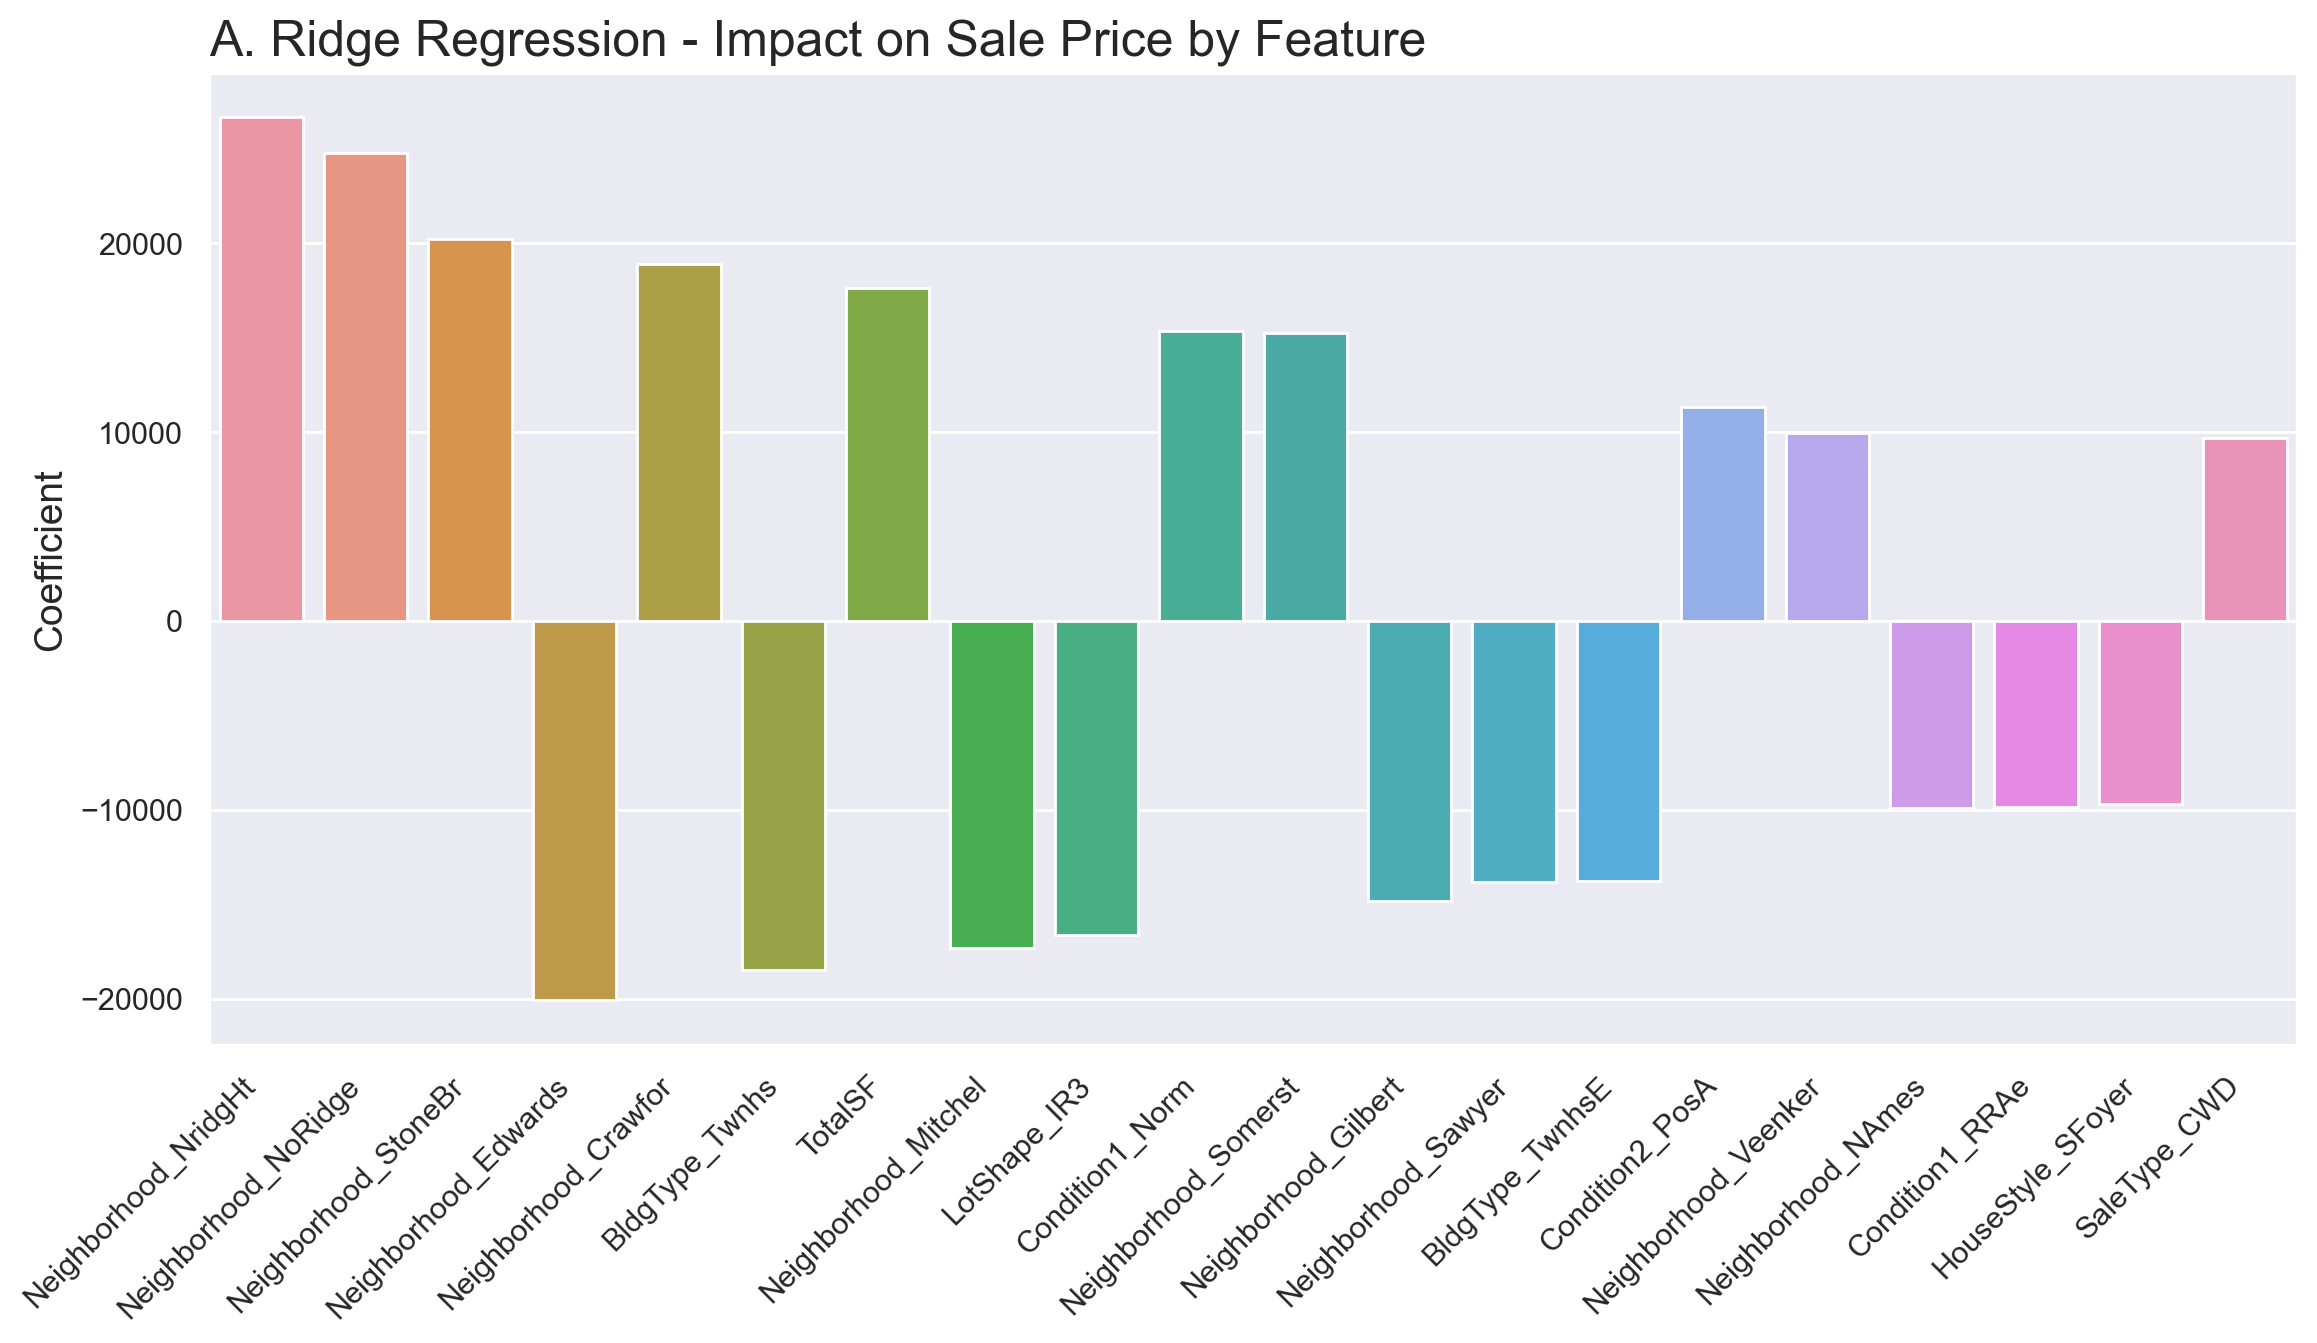

In [30]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=ridge_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('A. Ridge Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Elastic Net Regression with ElasticNetCV

In [31]:
# instantiate a ElasticnetCV model
opt_enet = ElasticNetCV(alphas=np.logspace(-4, 4, 10), l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                        max_iter = 100000, cv=10)

# fit the model
opt_enet.fit(X_train, y_train)

# display the optimal alpha and L1 ratio
print('Optimal Alpha:', opt_enet.alpha_)
print('Optimal L1 ratio:', opt_enet.l1_ratio_)

Optimal Alpha: 0.005994842503189409
Optimal L1 ratio: 0.1


In [32]:
# instantiate the model
enet = ElasticNet(alpha=opt_enet.alpha_, l1_ratio=opt_enet.l1_ratio_)

# fit the model
enet.fit(X_train, y_train)

# calculate the scores
a_enet_train = enet.score(X_train, y_train)
a_enet_test = enet.score(X_test, y_test)
a_enet_cv = (cross_val_score(enet, X_train, y_train, cv = 10)).mean()

a_enet_predictions_train = enet.predict(X_train)
a_enet_predictions = enet.predict(X_test)

a_enet_MSE = metrics.mean_squared_error(y_test, a_enet_predictions)
a_enet_MAE = metrics.mean_absolute_error(y_test, a_enet_predictions)

# collect the scores in a dataframe to compare different models later
a_enet_df = pd.DataFrame([{'train': a_enet_train,
                           'test' : a_enet_test,
                           'CV'   : a_enet_cv,
                           'MSE'  : a_enet_MSE,
                           'MAE'  : a_enet_MAE}],
                           index = ['A. Elastic Net Regression'])

# score the model
print('A. Elastic Net Regression Scores: \n')
print('R-squared train score: ', a_enet_train)
print('R-squared test score:  ', a_enet_test)
print('R-squared CV score:    ', a_enet_cv)
print('Mean Squared Error:    ', a_enet_MSE)
print('Mean Absolute Error:   ', a_enet_MAE)

A. Elastic Net Regression Scores: 

R-squared train score:  0.8339107848644768
R-squared test score:   0.8519815327853066
R-squared CV score:     0.7686513830560476
Mean Squared Error:     513969313.87715906
Mean Absolute Error:    16879.860020537104


In [33]:
# display the model intercept
print('Intercept:', enet.intercept_)

Intercept: 165558.5719787339


In [34]:
# collect the model coefficients in a dataframe
enet_coef = pd.DataFrame(list(zip(X_train.columns, enet.coef_)), columns = ['variable','coefficient'])
enet_coef['coef_abs'] = abs(enet_coef['coefficient'])

# display the largest model coefficients
enet_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable   coefficient      coef_abs
48  Neighborhood_NridgHt  27573.252150  27573.252150
47  Neighborhood_NoRidge  25708.369557  25708.369557
54  Neighborhood_StoneBr  21510.405757  21510.405757
39  Neighborhood_Edwards -20566.782775  20566.782775
73        BldgType_Twnhs -19641.169470  19641.169470
38  Neighborhood_Crawfor  19176.484781  19176.484781
43  Neighborhood_Mitchel -17785.870556  17785.870556
16               TotalSF  17578.315642  17578.315642
24          LotShape_IR3 -17533.039078  17533.039078
58       Condition1_Norm  16819.134105  16819.134105
53  Neighborhood_Somerst  15650.415110  15650.415110
40  Neighborhood_Gilbert -15123.994974  15123.994974
74       BldgType_TwnhsE -14552.814387  14552.814387
51   Neighborhood_Sawyer -14233.473655  14233.473655
67       Condition2_PosA  12903.213873  12903.213873
65       Condition2_None -10925.287465  10925.287465
61       Condition1_RRAe -10660.581917  10660.581917
56  Neighborhood_Veenker  10621.236884  10621.236884
92          SaleType_CWD  10603.579901  10603.579901
44    Neighborhood_NAmes -10217.821575  10217.821575

In [35]:
# display the coefficients which has been reduced to 0
enet_zeroed = enet_coef[enet_coef['coefficient'] == 0].shape[0]
print('Elastic Net Regression has zeroed',enet_zeroed , 'coefficients.')
list(enet_coef['variable'][enet_coef['coefficient'] == 0].values)

Elastic Net Regression has zeroed 0 coefficients.


[]

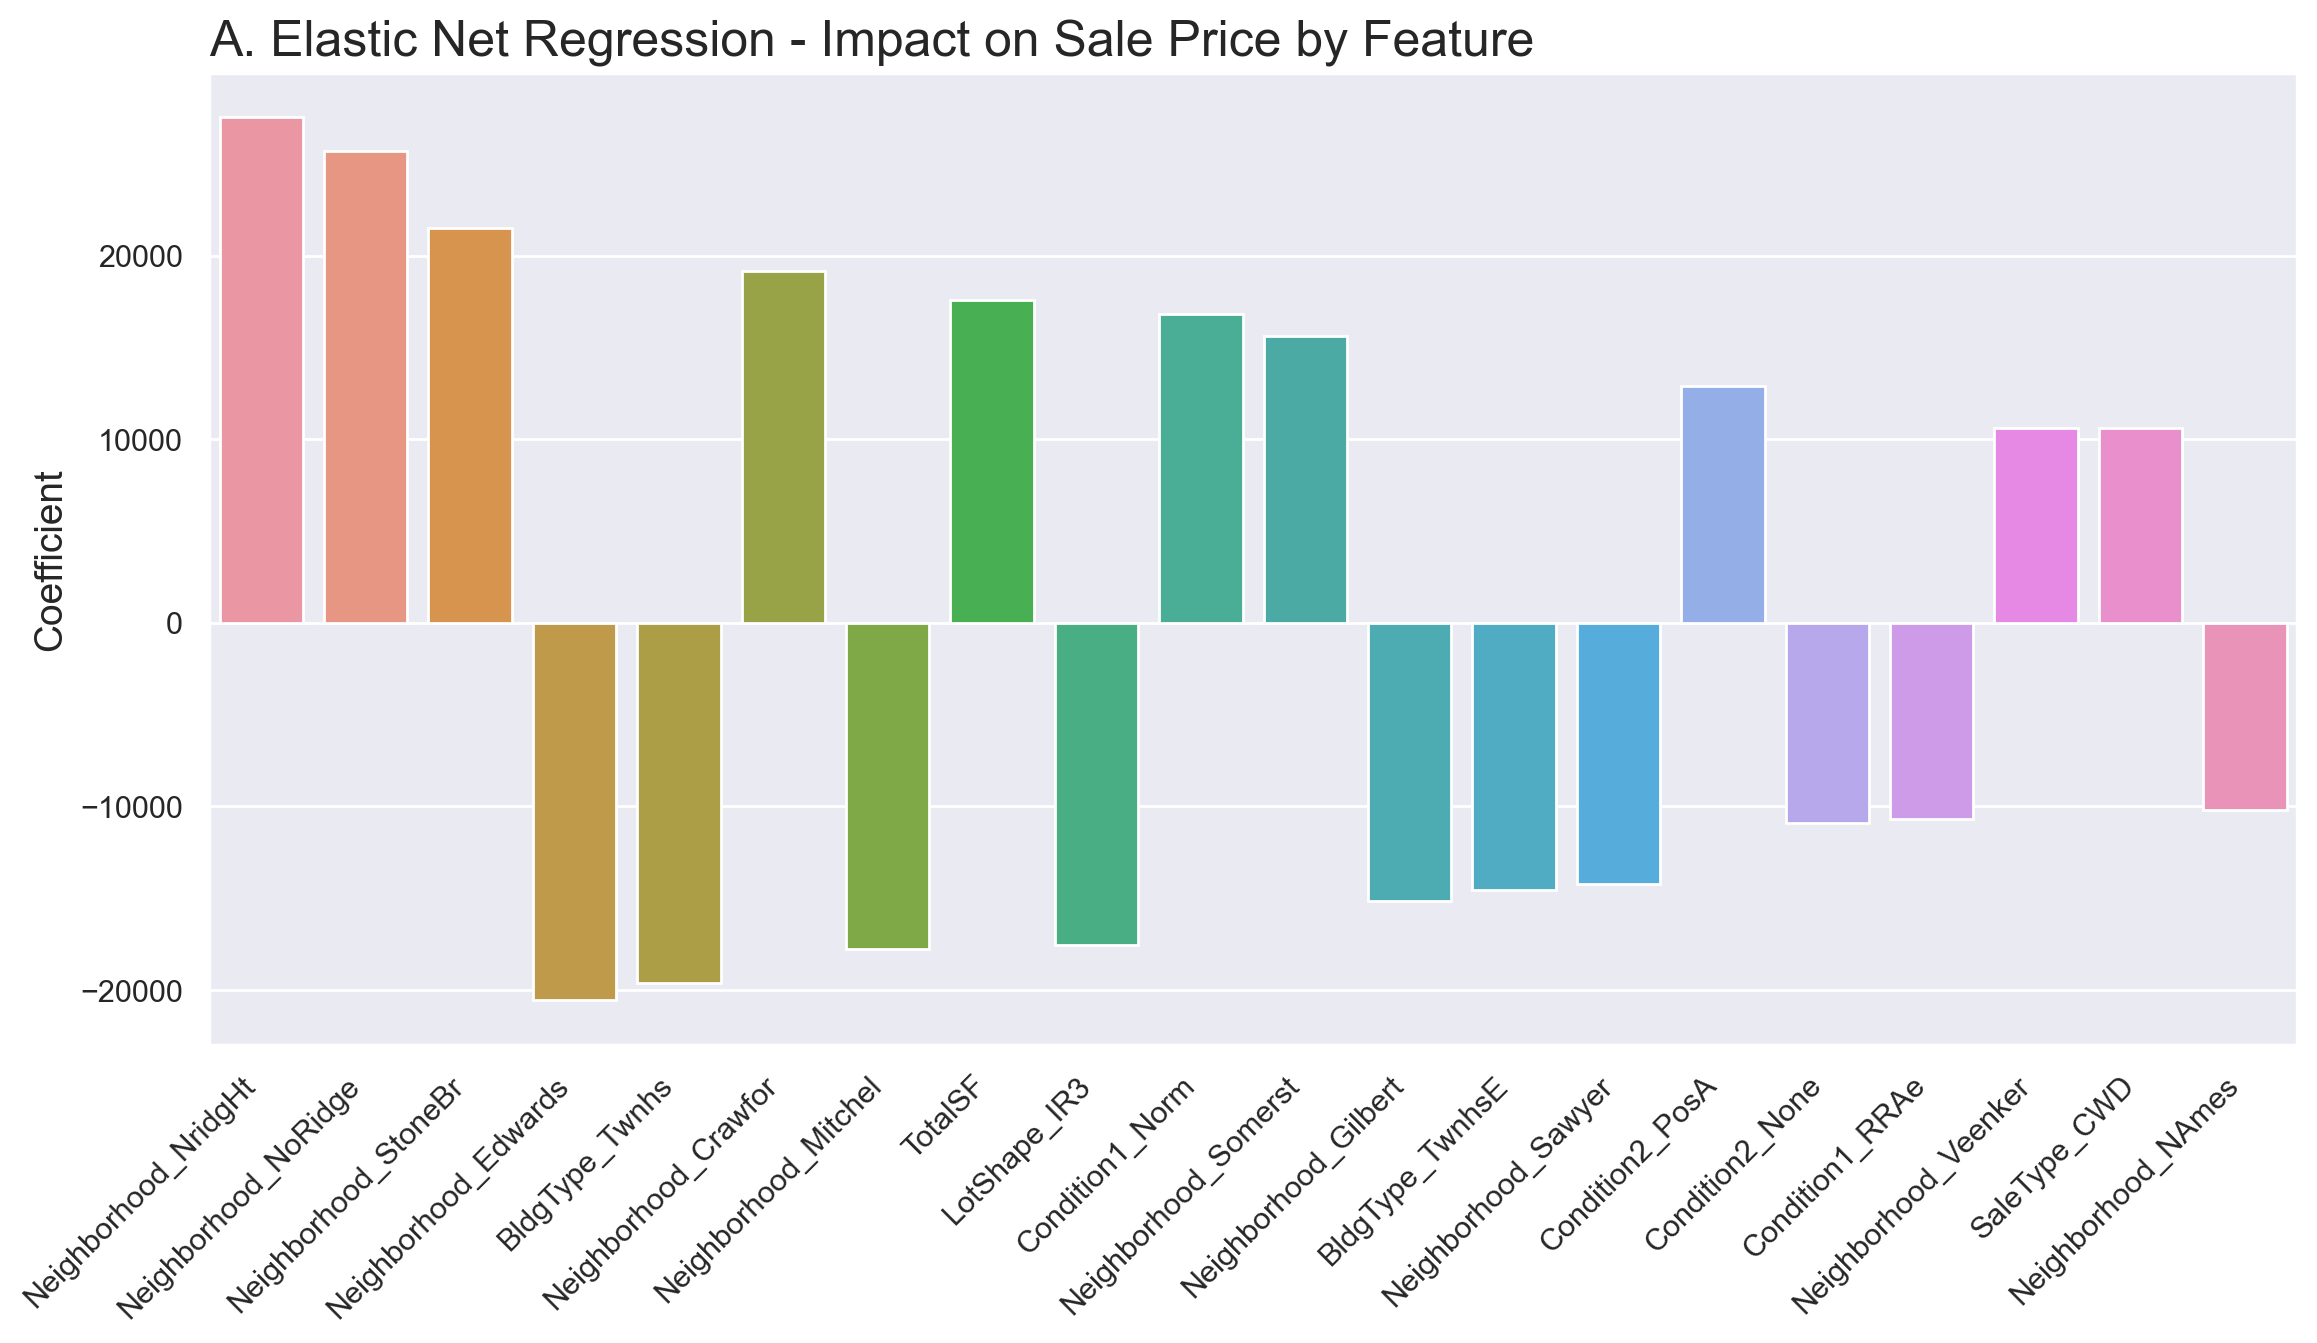

In [36]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=enet_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('A. Elastic Net Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Model Set Score Evaluation

In [37]:
A_models = pd.concat([a_linreg_df, a_lasso_df, a_ridge_df, a_enet_df], axis = 0)
A_models.round(decimals=5)

train          test            CV           MSE  \
A. Linear Regression       0.84435 -5.340567e+23 -2.351305e+23  1.854422e+33   
A. Lasso Regression        0.82640  8.516000e-01  7.693200e-01  5.153047e+08   
A. Ridge Regression        0.83282  8.518900e-01  7.688600e-01  5.142837e+08   
A. Elastic Net Regression  0.83391  8.519800e-01  7.686500e-01  5.139693e+08   

                                    MAE  
A. Linear Regression       3.352450e+15  
A. Lasso Regression        1.673720e+04  
A. Ridge Regression        1.685069e+04  
A. Elastic Net Regression  1.687986e+04

Among the four models implemented above, **Elastic Net Regression** achieved the highest test score of **0.8519**  

<br/><br/>

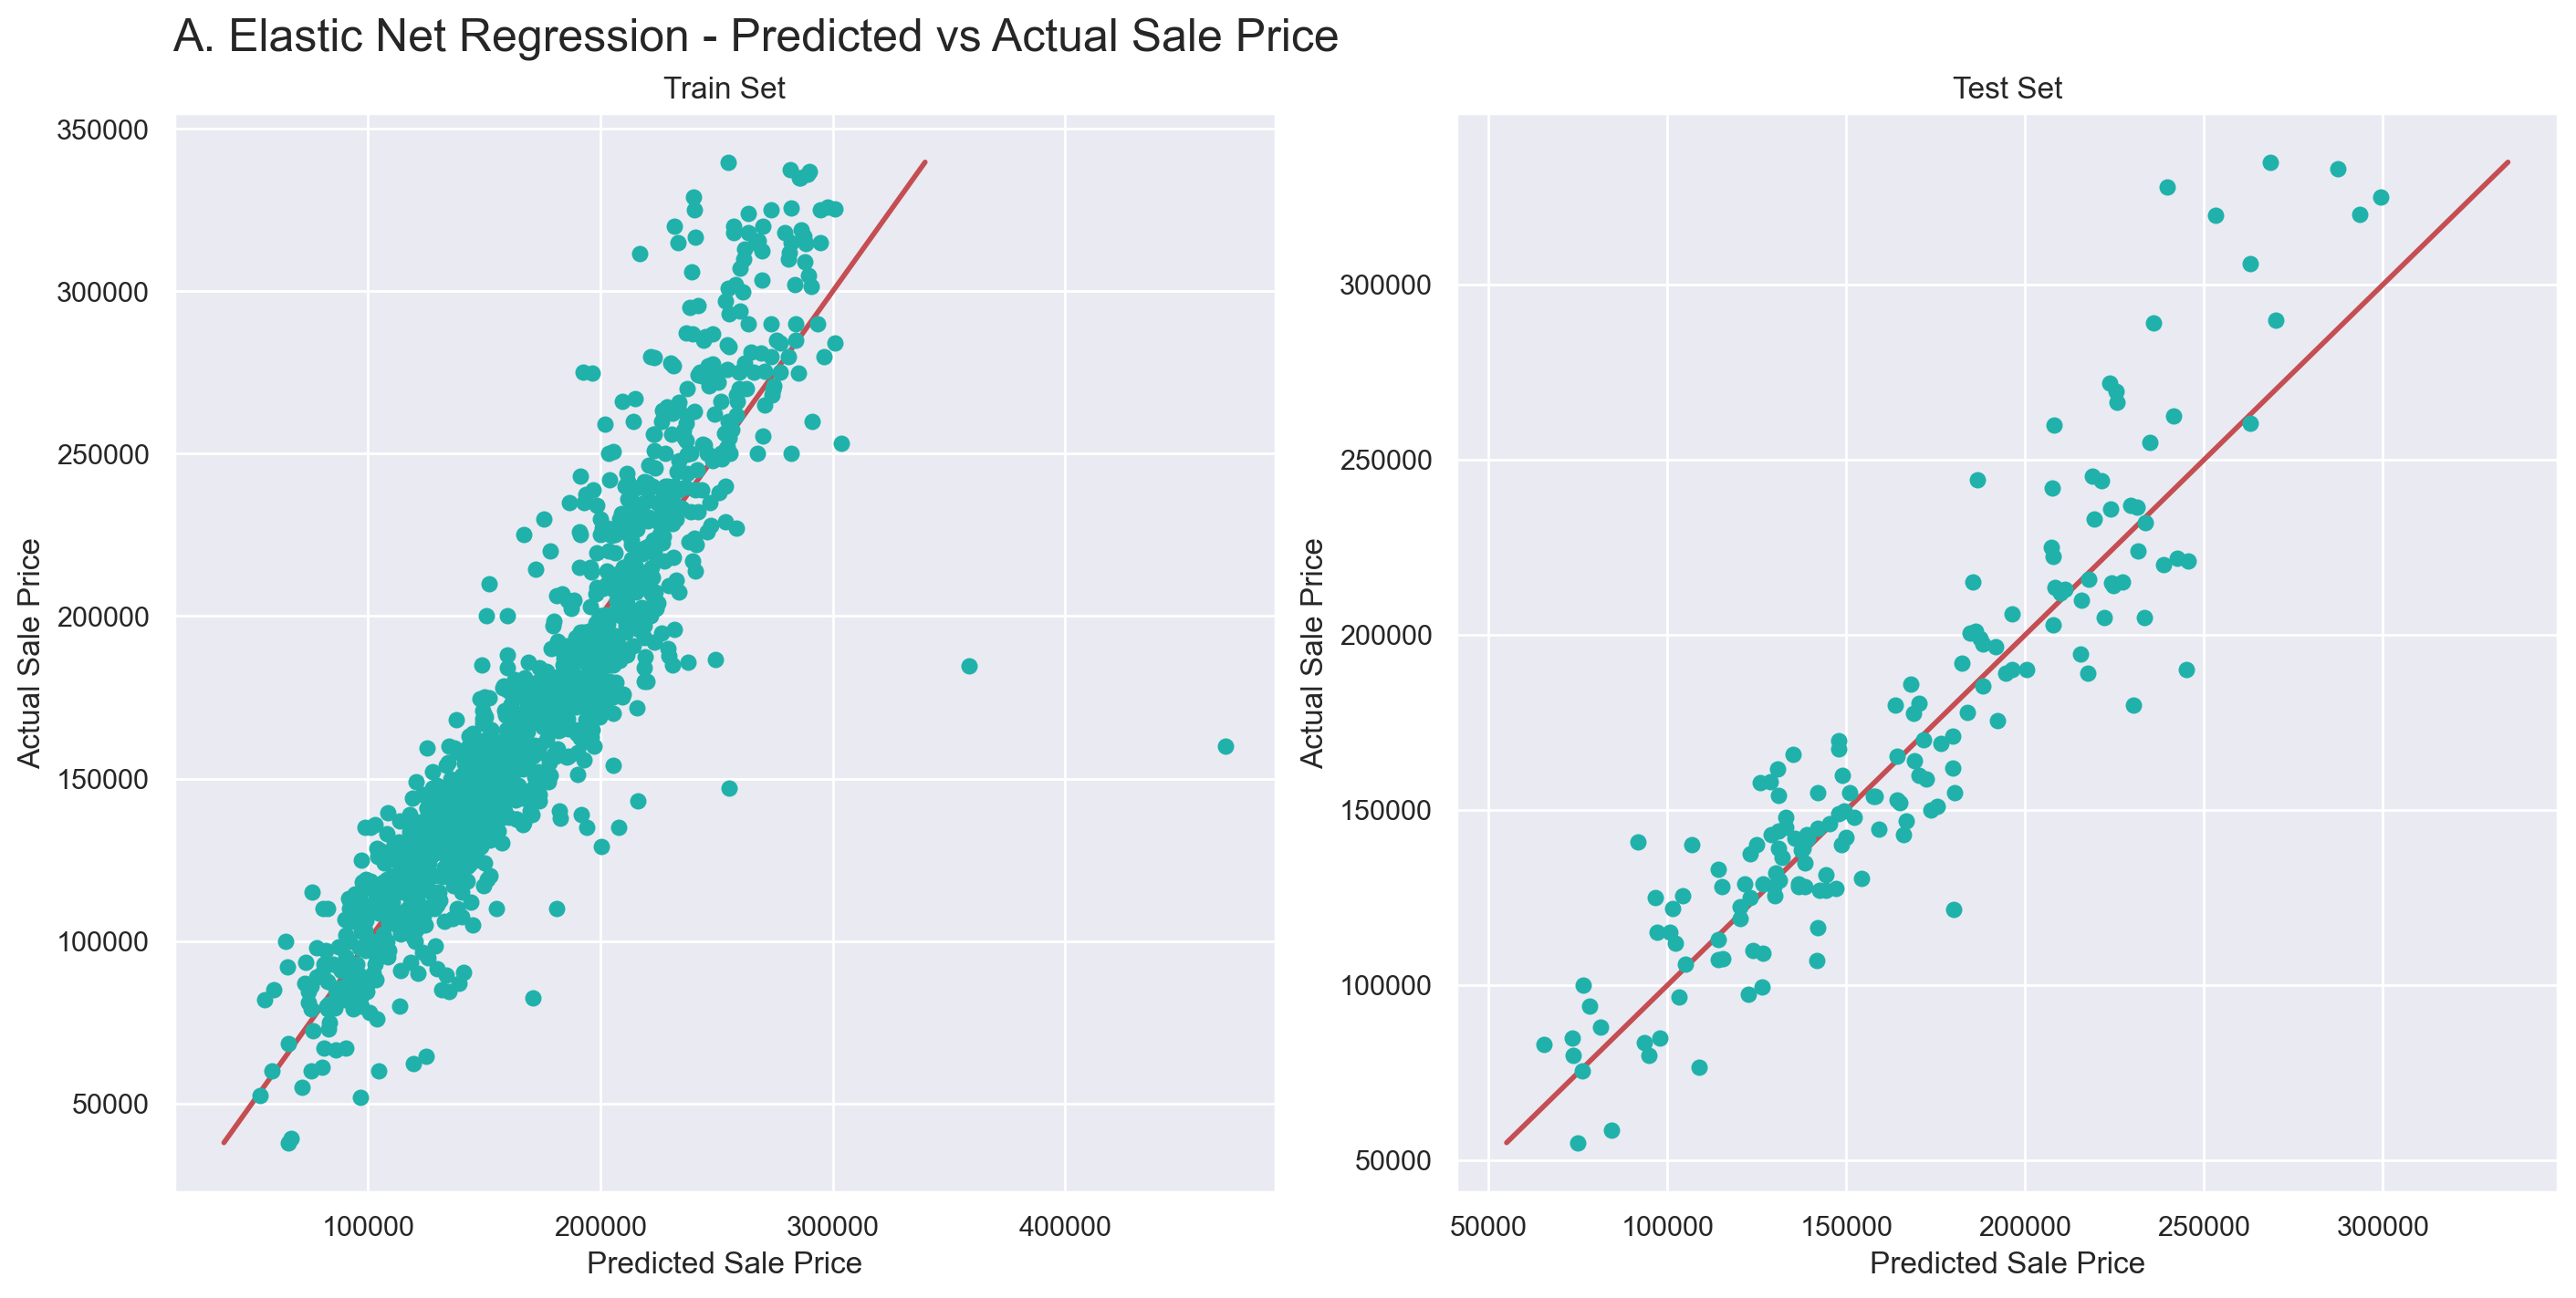

In [38]:
# plot the predicted y values against the actual y values by the elastic net method
fig, ax = plt.subplots(ncols=2, figsize=(14, 7), constrained_layout=True)

fig.suptitle('A. Elastic Net Regression - Predicted vs Actual Sale Price', x=0.52, horizontalalignment='right', fontsize=18)

ax[0].scatter(a_enet_predictions_train, y_train, s=30, color = 'lightseagreen', zorder=10)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r', lw=2)
ax[0].set_ylabel('Actual Sale Price')
ax[0].set_xlabel('Predicted Sale Price')
ax[0].set_title('Train Set')

ax[1].scatter(a_enet_predictions, y_test, s=30, color='lightseagreen', zorder=10)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r', lw=2)
ax[1].set_ylabel('Actual Sale Price')
ax[1].set_xlabel('Predicted Sale Price')
ax[1].set_title('Test Set')

plt.show()

In [39]:
# calculate the residuals for the elastic net method for the train dataset
a_resid_train = pd.DataFrame({'y_train': y_train, 'y_hat' : a_enet_predictions_train})
a_resid_train['residuals'] = a_resid_train['y_train'] - a_resid_train['y_hat']

# calculate the residuals for the lasso method for the test dataset
a_resid_test = pd.DataFrame({'y_test': y_test, 'y_hat' : a_enet_predictions})
a_resid_test['residuals'] = a_resid_test['y_test'] - a_resid_test['y_hat']

print(a_resid_test.shape)
a_resid_test.head(20)

(165, 3)


y_test          y_hat     residuals
15   149000  147819.133903   1180.866097
23   154000  158000.678560  -4000.678560
25   134800  138499.190489  -3699.190489
26   306000  262965.347633  43034.652367
31   165500  164206.470028   1293.529972
36   109000  126596.488592 -17596.488592
43   319900  253228.443660  66671.556340
50   110000  123759.057948 -13759.057948
59   140000  106662.107892  33337.892108
62   180000  230188.745755 -50188.745755
64    80000   73609.718162   6390.281838
69   144900  142057.850800   2842.149200
70   107400  114090.017840  -6690.017840
74   136500  132125.814700   4374.185300
92    83000   65432.755791  17567.244209
93   128950  121577.560188   7372.439812
94   205000  222064.943034 -17064.943034
95   178000  183737.728771  -5737.728771
97   198900  187481.796813  11418.203187
103  190000  200475.568029 -10475.568029

### Conclusions  


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [40]:
# load the data
df_m = pd.read_csv('datasets/house_03_mutable_optimised.csv')

In [41]:
# add YrSold to perform train/test split
df_m['YrSold'] = df_f['YrSold']

In [42]:
# dummify categorical variables
df_m_dum = pd.get_dummies(df_m, columns=[x for x in df_m.columns if x in nominal_vars], drop_first=True)

In [43]:
df_m_dum.head()

OverallQual  OverallCond  MasVnrArea  ExterCond  BsmtFinType1  \
0            7            5       196.0          3             6   
1            6            8         0.0          3             5   
2            7            5       162.0          3             6   
3            7            5         0.0          3             5   
4            8            5       350.0          3             6   

   BsmtFinType2  BsmtUnfSF  HeatingQC  CentralAir  LowQualFinSF  Functional  \
0             1        150          5           1             0           8   
1             1        284          5           1             0           8   
2             1        434          5           1             0           8   
3             1        540          4           1             0           8   
4             1        490          5           1             0           8   

   FireplaceQu  GarageFinish  GarageQual  PavedDrive  Fence  SalePrice  \
0            0             2           3           3      0     208500   
1            3             2           3           3      0     181500   
2            3             2           3           3      0     223500   
3            4             1           3           3      0     140000   
4            3             2           3           3      0     250000   

   YrSold  Alley_None  Alley_Pave  RoofMatl_CompShg  RoofMatl_Membran  \
0    2008           1           0                 1                 0   
1    2007           1           0                 1                 0   
2    2008           1           0                 1                 0   
3    2006           1           0                 1                 0   
4    2008           1           0                 1                 0   

   RoofMatl_Metal  RoofMatl_Roll  RoofMatl_Tar&Grv  RoofMatl_WdShake  \
0               0              0                 0                 0   
1               0              0                 0                 0   
2               0              0                 0                 0   
3               0              0                 0                 0   
4               0              0                 0                 0   

   RoofMatl_WdShngl  Exterior1st_AsphShn  Exterior1st_BrkComm  \
0                 0                    0                    0   
1                 0                    0                    0   
2                 0                    0                    0   
3                 0                    0                    0   
4                 0                    0                    0   

   Exterior1st_BrkFace  Exterior1st_CBlock  Exterior1st_CemntBd  \
0                    0                   0                    0   
1                    0                   0                    0   
2                    0                   0                    0   
3                    0                   0                    0   
4                    0                   0                    0   

   Exterior1st_HdBoard  Exterior1st_ImStucc  Exterior1st_MetalSd  \
0                    0                    0                    0   
1                    0                    0                    1   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   Exterior1st_Plywood  Exterior1st_Stone  Exterior1st_Stucco  \
0                    0                  0                   0   
1                    0                  0                   0   
2                    0                  0                   0   
3                    0                  0                   0   
4                    0                  0                   0   

   Exterior1st_VinylSd  Exterior1st_Wd Sdng  Exterior1st_WdShing  \
0                    1                    0                    0   
1                    0                    0                    0   
2   

In [44]:
# create a train-test split based on YrSold (pre-2010 is train, 2010 is test)
X_train = df_m_dum[df_m_dum['YrSold'] < 2010].copy()
X_test = df_m_dum[df_m_dum['YrSold'] == 2010].copy()

y_train = X_train.pop('SalePrice')
y_test = X_test.pop('SalePrice')

In [45]:
# drop YrSold since this is not a changeable feature
X_train.drop('YrSold', axis = 1, inplace = True)
X_test.drop('YrSold', axis = 1, inplace = True)

In [46]:
# check the shape of the modelling sets
print('Training set shape')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('')
print('Test set shape')
print('X:', X_test.shape)
print('y:', y_test.shape)

Training set shape
X: (1214, 65)
y: (1214,)

Test set shape
X: (165, 65)
y: (165,)


In [47]:
# select quantitative features which still are in the dataframe
quant_cols = [x for x in X_train.columns if x in quant_vars]

# rescale the numerical values in train and test sets
scaler = StandardScaler()
X_train[quant_cols] = scaler.fit_transform(X_train[quant_cols])
X_test[quant_cols] = scaler.transform(X_test[quant_cols])

### Linear Regression (without regularisation)

In [48]:
# instantiate the model
linreg = LinearRegression()

# fit the model
linreg.fit(X_train, y_train)

# calculate the scores
b_linreg_train = linreg.score(X_train, y_train)
b_linreg_test = linreg.score(X_test, y_test)
b_linreg_cv = (cross_val_score(linreg, X_train, y_train, cv = 10)).mean()

b_linreg_predictions_train = linreg.predict(X_train)
b_linreg_predictions = linreg.predict(X_test)

b_linreg_MSE = metrics.mean_squared_error(y_test, b_linreg_predictions)
b_linreg_MAE = metrics.mean_absolute_error(y_test, b_linreg_predictions)

# collect the scores in a dataframe to compare different models later
b_linreg_df = pd.DataFrame([{'train': b_linreg_train,
                             'test' : b_linreg_test,
                             'CV'   : b_linreg_cv,
                             'MSE'  : b_linreg_MSE,
                             'MAE'  : b_linreg_MAE}],
                             index = ['B. Linear Regression'])

# score the model
print('B. Linear Regression Scores: \n')
print('R-squared train score: ', b_linreg_train)
print('R-squared test score:  ', b_linreg_test)
print('R-squared CV score:    ', b_linreg_cv)
print('Mean Squared Error:    ', b_linreg_MSE)
print('Mean Absolute Error:   ', b_linreg_MAE)

B. Linear Regression Scores: 

R-squared train score:  0.7341012523406081
R-squared test score:   -6.784484718421115e+24
R-squared CV score:     -2.3773022882501372e+23
Mean Squared Error:     2.355798584699049e+34
Mean Absolute Error:    1.1948877428466816e+16


In [49]:
# display the model intercept
print('Intercept:', linreg.intercept_)

Intercept: -214600.42778831927


In [50]:
# collect the model coefficients in a dataframe
linreg_coef = pd.DataFrame(list(zip(X_train.columns, linreg.coef_)), columns = ['variable','coefficient'])
linreg_coef['coef_abs'] = abs(linreg_coef['coefficient'])

# display the largest model coefficients
linreg_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable   coefficient      coef_abs
25  Exterior1st_AsphShn  1.971565e+18  1.971565e+18
24     RoofMatl_WdShngl  1.954489e+05  1.954489e+05
19     RoofMatl_Membran  1.928580e+05  1.928580e+05
22     RoofMatl_Tar&Grv  1.869119e+05  1.869119e+05
18     RoofMatl_CompShg  1.649642e+05  1.649642e+05
23     RoofMatl_WdShake  1.648896e+05  1.648896e+05
20       RoofMatl_Metal  1.608604e+05  1.608604e+05
21        RoofMatl_Roll  1.393306e+05  1.393306e+05
46    Exterior2nd_Other  7.254086e+04  7.254086e+04
59         Heating_OthW -4.261414e+04  4.261414e+04
28   Exterior1st_CBlock -3.913989e+04  3.913989e+04
26  Exterior1st_BrkComm -3.473690e+04  3.473690e+04
63       Electrical_Mix -3.261820e+04  3.261820e+04
38  Exterior1st_WdShing -3.004001e+04  3.004001e+04
31  Exterior1st_ImStucc  2.962614e+04  2.962614e+04
42  Exterior2nd_HdBoard  2.607505e+04  2.607505e+04
60         Heating_Wall  2.497186e+04  2.497186e+04
0           OverallQual  2.296031e+04  2.296031e+04
40  Exterior2nd_BrkComm -2.095841e+04  2.095841e+04
41  Exterior2nd_BrkFace -1.896200e+04  1.896200e+04

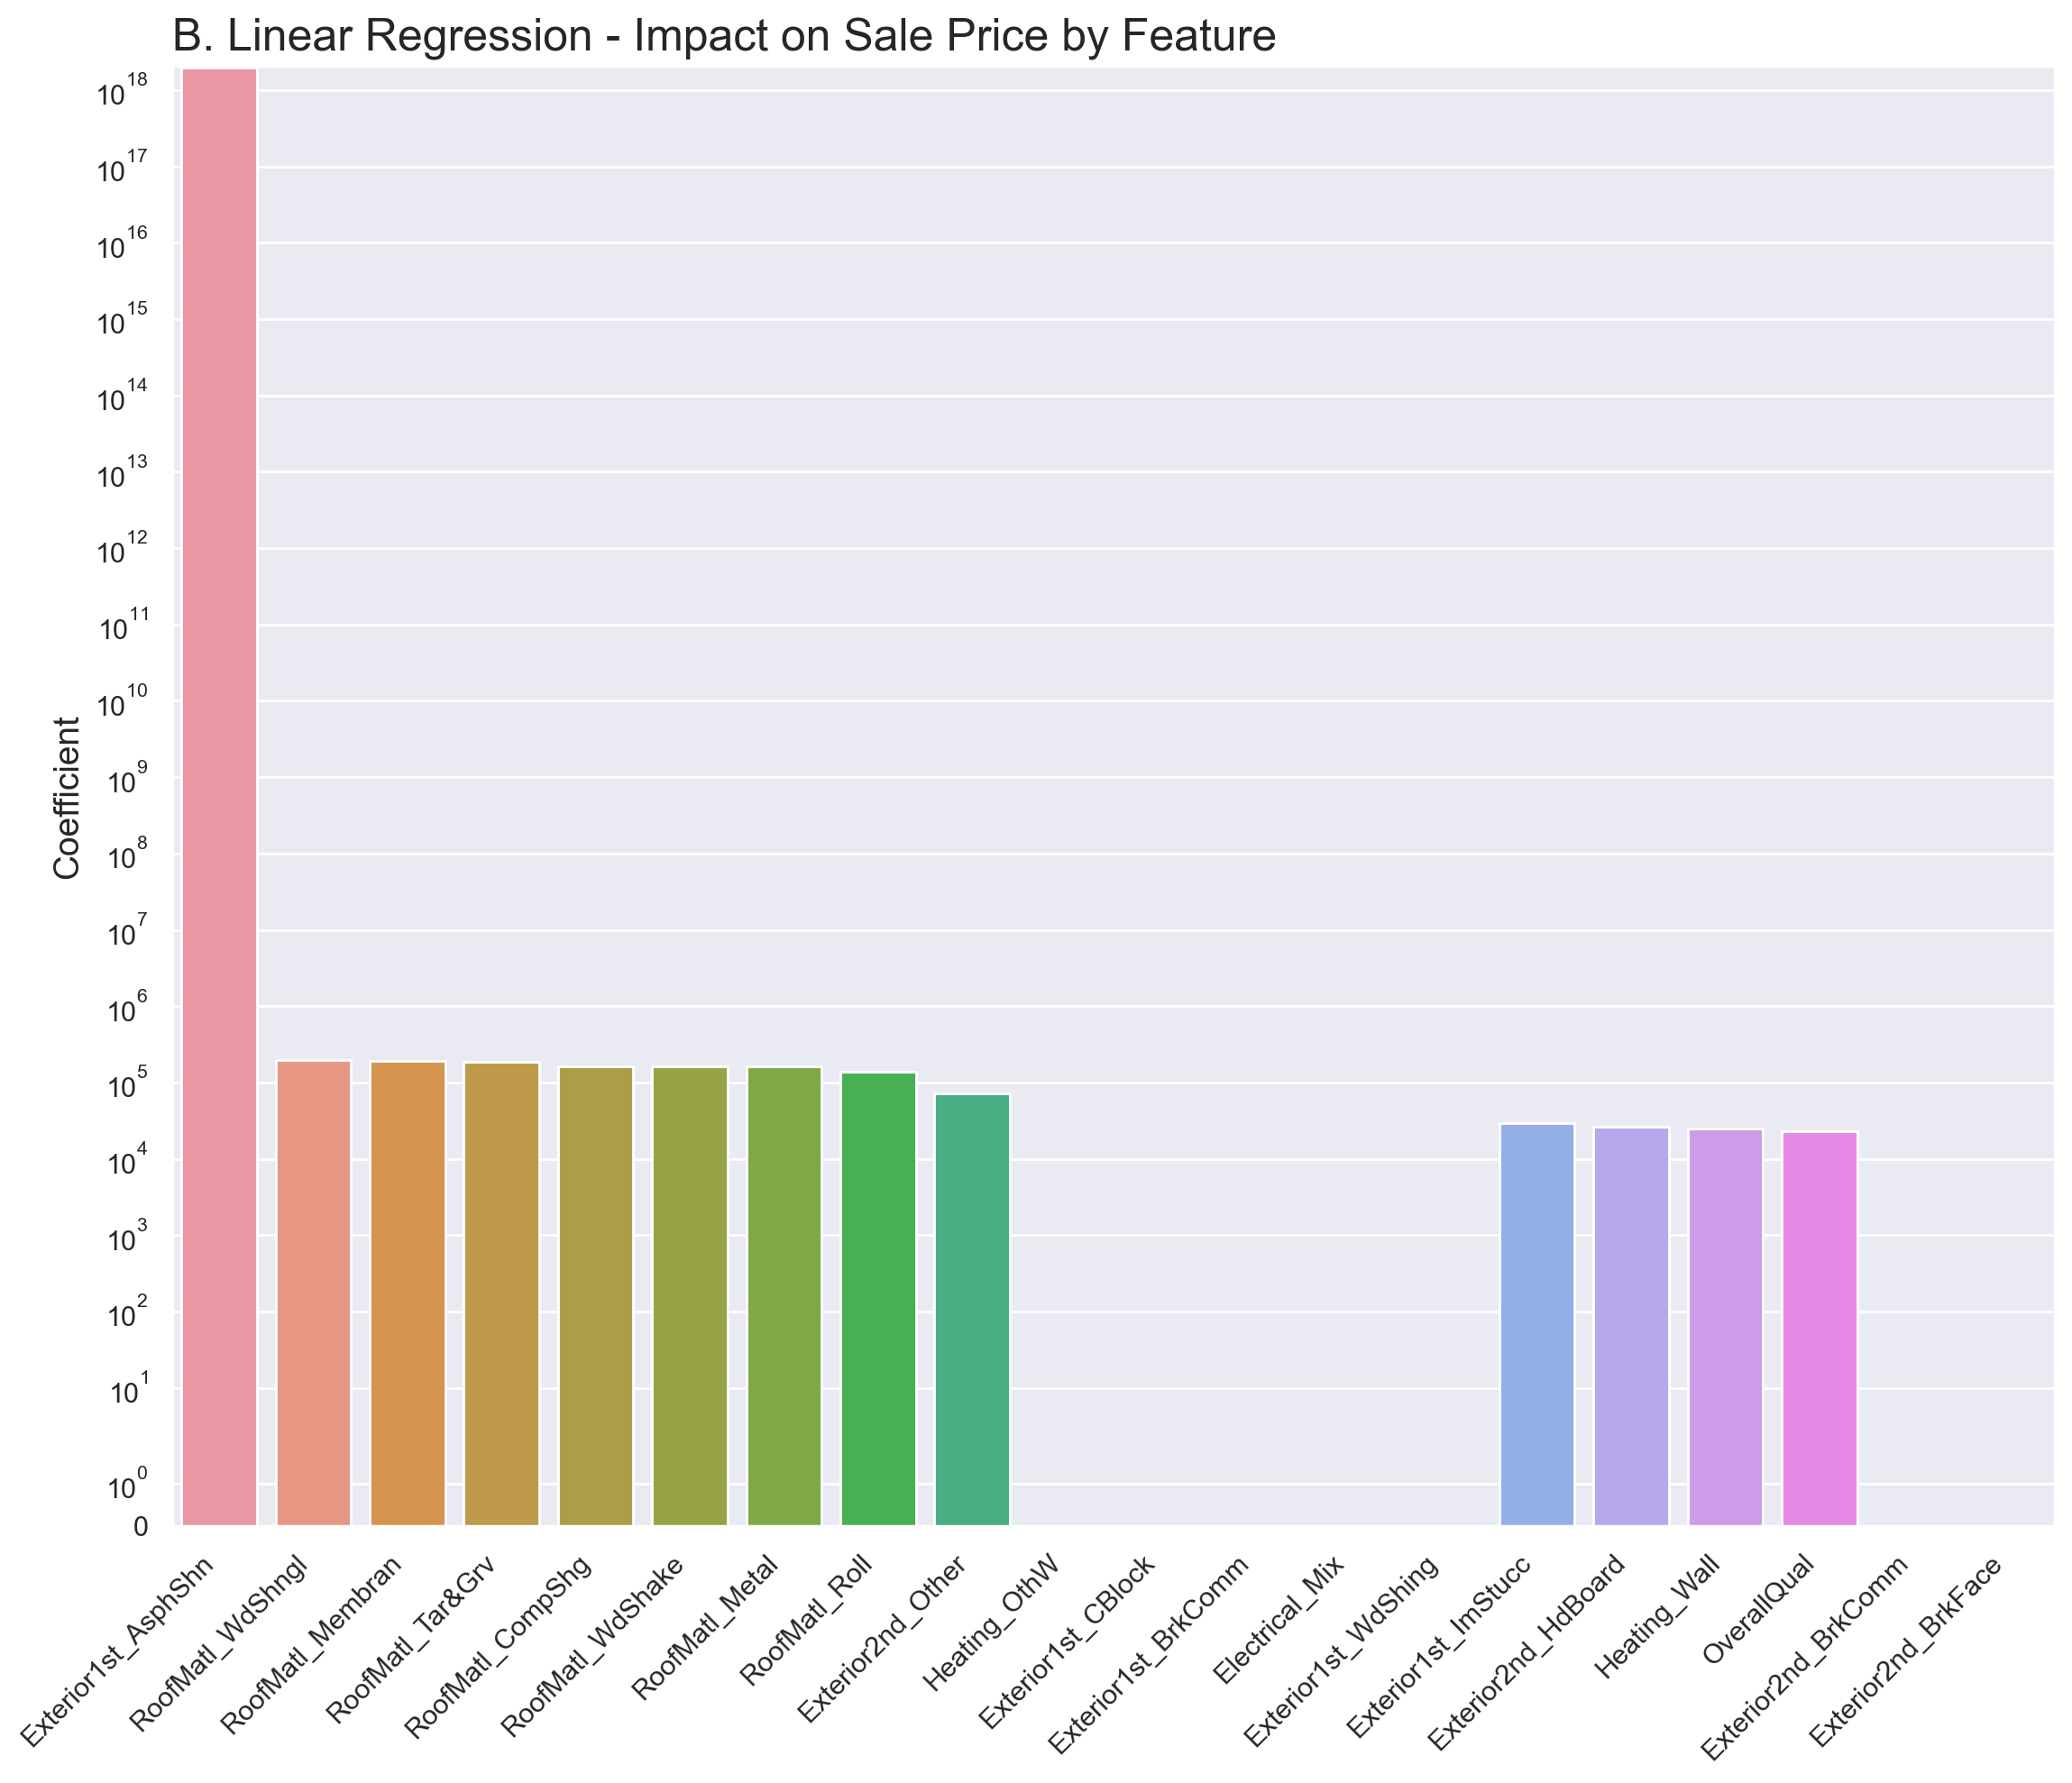

In [51]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,10))

sns.barplot(data=linreg_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('B. Linear Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.yscale('symlog')

plt.show()

### Lasso Regression with LassoCV

In [52]:
# instantiate a LassoCV model
opt_lasso = LassoCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_lasso.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_lasso.alpha_)

Optimal Alpha: 45.5293507486695


In [53]:
# instantiate the model
lasso = Lasso(alpha=opt_lasso.alpha_)

# fit the model
lasso.fit(X_train, y_train)

# calculate the scores
b_lasso_train = lasso.score(X_train, y_train)
b_lasso_test = lasso.score(X_test, y_test)
b_lasso_cv = (cross_val_score(lasso, X_train, y_train, cv = 10)).mean()

b_lasso_predictions_train = lasso.predict(X_train)
b_lasso_predictions = lasso.predict(X_test)

b_lasso_MSE = metrics.mean_squared_error(y_test, b_lasso_predictions)
b_lasso_MAE = metrics.mean_absolute_error(y_test, b_lasso_predictions)

# collect the scores in a dataframe to compare different models later
b_lasso_df = pd.DataFrame([{'train': b_lasso_train,
                            'test' : b_lasso_test,
                            'CV'   : b_lasso_cv,
                            'MSE'  : b_lasso_MSE,
                            'MAE'  : b_lasso_MAE}],
                            index = ['B. Lasso Regression'])

# score the model
print('B. Lasso Regression Scores: \n')
print('R-squared train score: ', b_lasso_train)
print('R-squared test score:  ', b_lasso_test)
print('R-squared CV score:    ', b_lasso_cv)
print('Mean Squared Error:    ', b_lasso_MSE)
print('Mean Absolute Error:   ', b_lasso_MAE)

B. Lasso Regression Scores: 

R-squared train score:  0.7232749243838299
R-squared test score:   0.6990927915968779
R-squared CV score:     0.6961444395221422
Mean Squared Error:     1044849837.6849265
Mean Absolute Error:    24315.169219397743


In [54]:
# display the model intercept
print('Intercept:', lasso.intercept_)

Intercept: -54425.6874776468


In [55]:
# collect the model coefficients in a dataframe
lasso_coef = pd.DataFrame(list(zip(X_train.columns, lasso.coef_)), columns = ['variable','coefficient'])
lasso_coef['coef_abs'] = abs(lasso_coef['coefficient'])

# display the largest model coefficients
lasso_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable   coefficient      coef_abs
0           OverallQual  22777.284784  22777.284784
38  Exterior1st_WdShing -20056.775202  20056.775202
60         Heating_Wall  18502.026492  18502.026492
52  Exterior2nd_WdShing -18204.237719  18204.237719
40  Exterior2nd_BrkComm -15998.664556  15998.664556
57         Heating_GasW  15877.606755  15877.606755
24     RoofMatl_WdShngl  14316.292780  14316.292780
22     RoofMatl_Tar&Grv  13733.145820  13733.145820
35   Exterior1st_Stucco -11854.463592  11854.463592
42  Exterior2nd_HdBoard  11454.914735  11454.914735
46    Exterior2nd_Other   8642.743432   8642.743432
27  Exterior1st_BrkFace   7365.851831   7365.851831
12         GarageFinish   6903.754019   6903.754019
30  Exterior1st_HdBoard  -6674.239147   6674.239147
37  Exterior1st_Wd Sdng  -6535.762031   6535.762031
33  Exterior1st_Plywood   6296.395096   6296.395096
11          FireplaceQu   6231.291861   6231.291861
7             HeatingQC   5514.622475   5514.622475
47  Exterior2nd_Plywood   5235.441673   5235.441673
2            MasVnrArea   5125.619309   5125.619309

In [56]:
# display the coefficients which has been reduced to 0
lasso_zeroed = lasso_coef[lasso_coef['coefficient'] == 0].shape[0]
print('Lasso Regression has zeroed',lasso_zeroed , 'coefficients.')
list(lasso_coef['variable'][lasso_coef['coefficient'] == 0].values)

Lasso Regression has zeroed 24 coefficients.


['Alley_Pave',
 'RoofMatl_CompShg',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_WdShake',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_AsphShn',
 'Exterior2nd_BrkFace',
 'Exterior2nd_ImStucc',
 'Exterior2nd_MetalSd',
 'Exterior2nd_Stone',
 'Exterior2nd_Stucco',
 'Exterior2nd_VinylSd',
 'MasVnrType_None',
 'Heating_GasA',
 'Heating_Grav',
 'Electrical_FuseF',
 'Electrical_FuseP',
 'Electrical_Mix']

In [57]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=lasso_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('B. Lasso Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Ridge Regression with RidgeCV

In [58]:
# instantiate a RidgeCV model
opt_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_ridge.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_ridge.alpha_)

Optimal Alpha: 36.12342699709432


In [59]:
# instantiate the model
ridge = Ridge(alpha=opt_ridge.alpha_)

# fit the model
ridge.fit(X_train, y_train)

# calculate the scores
b_ridge_train = ridge.score(X_train, y_train)
b_ridge_test = ridge.score(X_test, y_test)
b_ridge_cv = (cross_val_score(ridge, X_train, y_train, cv = 10)).mean()

b_ridge_predictions_train = ridge.predict(X_train)
b_ridge_predictions = ridge.predict(X_test)

b_ridge_MSE = metrics.mean_squared_error(y_test, b_ridge_predictions)
b_ridge_MAE = metrics.mean_absolute_error(y_test, b_ridge_predictions)

# collect the scores in a dataframe to compare different models later
b_ridge_df = pd.DataFrame([{'train': b_ridge_train,
                            'test' : b_ridge_test,
                            'CV'   : b_ridge_cv,
                            'MSE'  : b_ridge_MSE,
                            'MAE'  : b_ridge_MAE}],
                            index = ['B. Ridge Regression'])

# score the model
print('B. Ridge Regression Scores: \n')
print('R-squared train score: ', b_ridge_train)
print('R-squared test score:  ', b_ridge_test)
print('R-squared CV score:    ', b_ridge_cv)
print('Mean Squared Error:    ', b_ridge_MSE)
print('Mean Absolute Error:   ', b_ridge_MAE)

B. Ridge Regression Scores: 

R-squared train score:  0.7177561498067515
R-squared test score:   0.6937708593883105
R-squared CV score:     0.6989965378105988
Mean Squared Error:     1063329355.1208875
Mean Absolute Error:    24578.488145716205


In [60]:
# display the model intercept
print('Intercept:', ridge.intercept_)

Intercept: -44673.8517457814


In [61]:
# collect the model coefficients in a dataframe
ridge_coef = pd.DataFrame(list(zip(X_train.columns, ridge.coef_)), columns = ['variable','coefficient'])
ridge_coef['coef_abs'] = abs(ridge_coef['coefficient'])

# display the largest model coefficients
ridge_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable   coefficient      coef_abs
0           OverallQual  22088.072624  22088.072624
12         GarageFinish   7291.364730   7291.364730
38  Exterior1st_WdShing  -7236.929167   7236.929167
52  Exterior2nd_WdShing  -6586.829913   6586.829913
27  Exterior1st_BrkFace   6329.138640   6329.138640
11          FireplaceQu   6248.131746   6248.131746
33  Exterior1st_Plywood   5995.380700   5995.380700
7             HeatingQC   5457.602762   5457.602762
2            MasVnrArea   5062.417457   5062.417457
57         Heating_GasW   4683.675949   4683.675949
35   Exterior1st_Stucco  -4675.822263   4675.822263
36  Exterior1st_VinylSd   4630.331280   4630.331280
37  Exterior1st_Wd Sdng  -4397.169287   4397.169287
30  Exterior1st_HdBoard  -4349.955014   4349.955014
22     RoofMatl_Tar&Grv   3888.388903   3888.388903
16           Alley_None   3878.371000   3878.371000
56         Heating_GasA  -3762.244283   3762.244283
4          BsmtFinType1   3760.164317   3760.164317
29  Exterior1st_CemntBd   3703.877988   3703.877988
55     MasVnrType_Stone   3701.956065   3701.956065

In [62]:
# display the coefficients which has been reduced to 0
ridge_zeroed = ridge_coef[ridge_coef['coefficient'] == 0].shape[0]
print('Ridge Regression has zeroed',ridge_zeroed , 'coefficients.')
list(ridge_coef['variable'][ridge_coef['coefficient'] == 0].values)

Ridge Regression has zeroed 1 coefficients.


['Exterior1st_AsphShn']

In [63]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=ridge_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('B. Ridge Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Elastic Net Regression with ElasticNetCV

In [64]:
# instantiate a ElasticnetCV model
opt_enet = ElasticNetCV(alphas=np.logspace(-4, 4, 10), l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                        max_iter = 100000, cv=10)

# fit the model
opt_enet.fit(X_train, y_train)

# display the optimal alpha and L1 ratio
print('Optimal Alpha:', opt_enet.alpha_)
print('Optimal L1 ratio:', opt_enet.l1_ratio_)

Optimal Alpha: 0.046415888336127774
Optimal L1 ratio: 0.5


In [65]:
# instantiate the model
enet = ElasticNet(alpha=opt_enet.alpha_, l1_ratio=opt_enet.l1_ratio_)

# fit the model
enet.fit(X_train, y_train)

# calculate the scores
b_enet_train = enet.score(X_train, y_train)
b_enet_test = enet.score(X_test, y_test)
b_enet_cv = (cross_val_score(enet, X_train, y_train, cv = 10)).mean()

b_enet_predictions_train = enet.predict(X_train)
b_enet_predictions = enet.predict(X_test)

b_enet_MSE = metrics.mean_squared_error(y_test, b_enet_predictions)
b_enet_MAE = metrics.mean_absolute_error(y_test, b_enet_predictions)

# collect the scores in a dataframe to compare different models later
b_enet_df = pd.DataFrame([{'train': b_enet_train,
                           'test' : b_enet_test,
                           'CV'   : b_enet_cv,
                           'MSE'  : b_enet_MSE,
                           'MAE'  : b_enet_MAE}],
                           index = ['B. Elastic Net Regression'])

# score the model
print('B. Elastic Net Regression Scores: \n')
print('R-squared train score: ', b_enet_train)
print('R-squared test score:  ', b_enet_test)
print('R-squared CV score:    ', b_enet_cv)
print('Mean Squared Error:    ', b_enet_MSE)
print('Mean Absolute Error:   ', b_enet_MAE)

B. Elastic Net Regression Scores: 

R-squared train score:  0.7187145531541337
R-squared test score:   0.694842784133713
R-squared CV score:     0.6989291240473159
Mean Squared Error:     1059607276.1378415
Mean Absolute Error:    24535.615243730903


In [66]:
# display the model intercept
print('Intercept:', enet.intercept_)

Intercept: -45032.6756300698


In [67]:
# collect the model coefficients in a dataframe
enet_coef = pd.DataFrame(list(zip(X_train.columns, enet.coef_)), columns = ['variable','coefficient'])
enet_coef['coef_abs'] = abs(enet_coef['coefficient'])

# display the largest model coefficients
enet_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable   coefficient      coef_abs
0           OverallQual  22198.852656  22198.852656
38  Exterior1st_WdShing  -8450.311541   8450.311541
52  Exterior2nd_WdShing  -7723.236463   7723.236463
12         GarageFinish   7245.447391   7245.447391
27  Exterior1st_BrkFace   6992.705843   6992.705843
33  Exterior1st_Plywood   6433.715621   6433.715621
11          FireplaceQu   6227.042999   6227.042999
7             HeatingQC   5487.029344   5487.029344
35   Exterior1st_Stucco  -5437.316483   5437.316483
57         Heating_GasW   5409.746915   5409.746915
2            MasVnrArea   5104.744027   5104.744027
36  Exterior1st_VinylSd   4728.139553   4728.139553
22     RoofMatl_Tar&Grv   4611.364119   4611.364119
37  Exterior1st_Wd Sdng  -4522.833197   4522.833197
30  Exterior1st_HdBoard  -4485.062350   4485.062350
16           Alley_None   4191.965501   4191.965501
56         Heating_GasA  -4156.677080   4156.677080
29  Exterior1st_CemntBd   4079.981719   4079.981719
55     MasVnrType_Stone   3858.105584   3858.105584
42  Exterior2nd_HdBoard   3841.933285   3841.933285

In [68]:
# display the coefficients which has been reduced to 0
enet_zeroed = enet_coef[enet_coef['coefficient'] == 0].shape[0]
print('Elastic Net Regression has zeroed',enet_zeroed , 'coefficients.')
list(enet_coef['variable'][enet_coef['coefficient'] == 0].values)

Elastic Net Regression has zeroed 1 coefficients.


['Exterior1st_AsphShn']

In [69]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=enet_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('B. Elastic Net Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Model Set Score Evaluation

In [70]:
B_models = pd.concat([b_linreg_df, b_lasso_df, b_ridge_df, b_enet_df], axis = 0)
B_models.round(decimals=5)

train          test            CV           MSE  \
B. Linear Regression       0.73410 -6.784485e+24 -2.377302e+23  2.355799e+34   
B. Lasso Regression        0.72327  6.990900e-01  6.961400e-01  1.044850e+09   
B. Ridge Regression        0.71776  6.937700e-01  6.990000e-01  1.063329e+09   
B. Elastic Net Regression  0.71871  6.948400e-01  6.989300e-01  1.059607e+09   

                                    MAE  
B. Linear Regression       1.194888e+16  
B. Lasso Regression        2.431517e+04  
B. Ridge Regression        2.457849e+04  
B. Elastic Net Regression  2.453562e+04

In [71]:
### COMMENTS



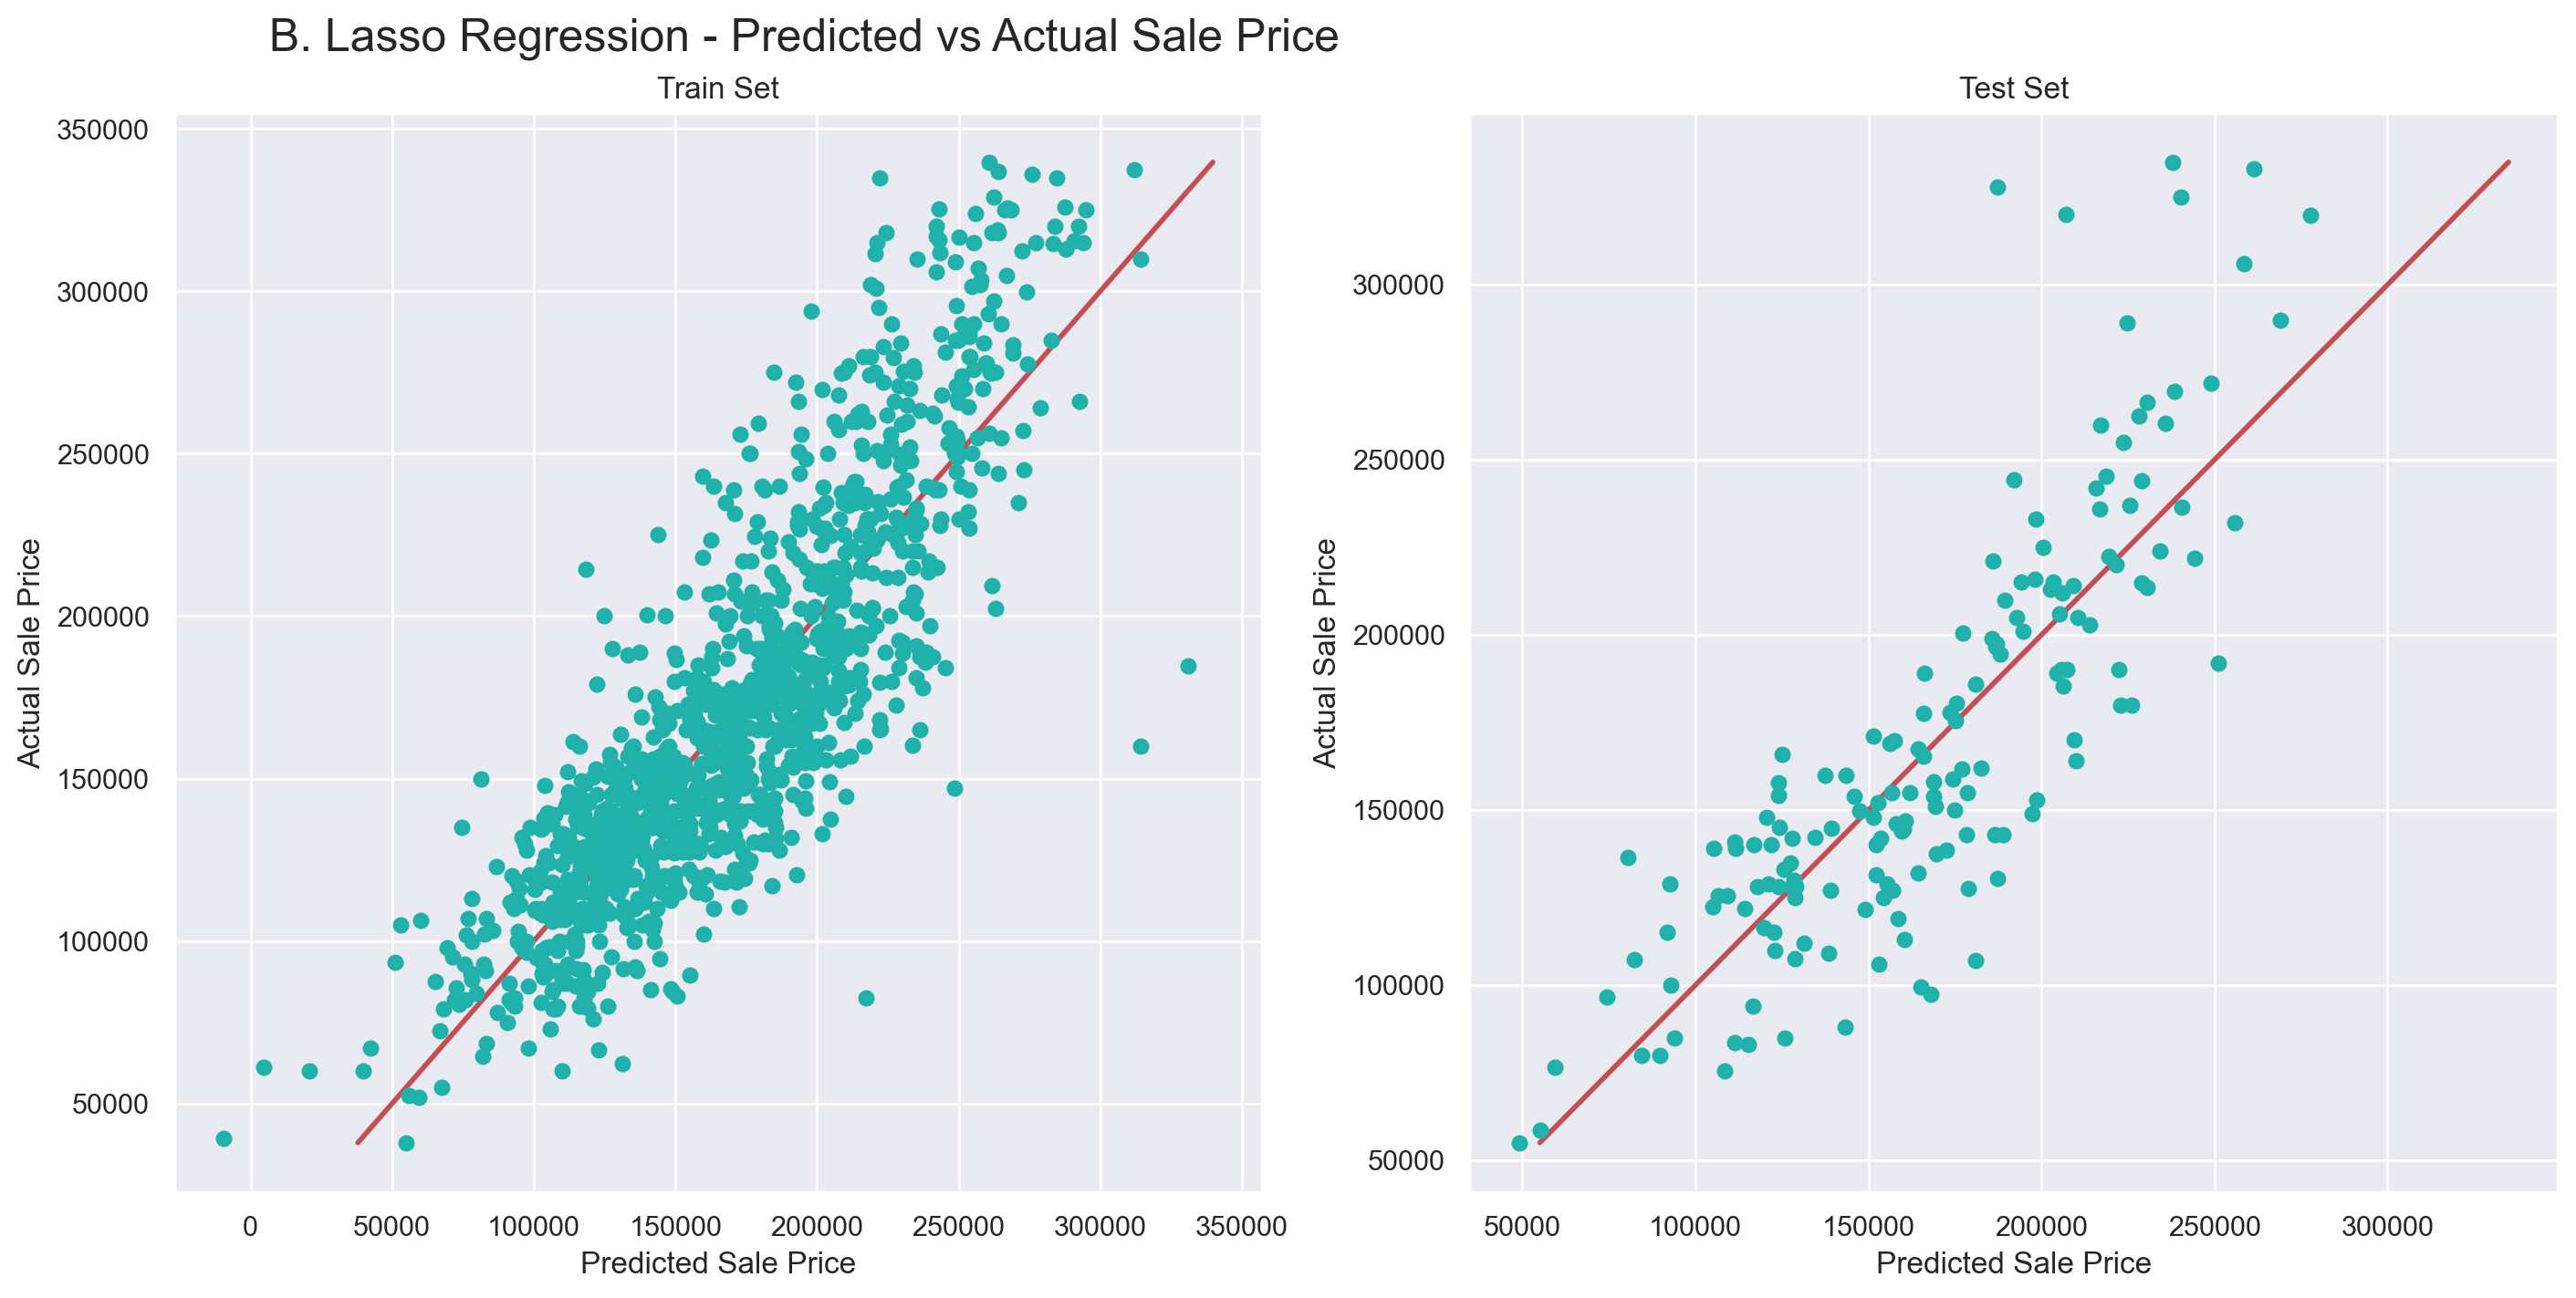

In [72]:
# plot the predicted y values against the actual y values by the lasso method
fig, ax = plt.subplots(ncols=2, figsize=(14, 7), constrained_layout=True)

fig.suptitle('B. Lasso Regression - Predicted vs Actual Sale Price', x=0.52, horizontalalignment='right', fontsize=18)

ax[0].scatter(b_lasso_predictions_train, y_train, s=30, color = 'lightseagreen', zorder=10)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r', lw=2)
ax[0].set_ylabel('Actual Sale Price')
ax[0].set_xlabel('Predicted Sale Price')
ax[0].set_title('Train Set')

ax[1].scatter(b_lasso_predictions, y_test, s=30, color='lightseagreen', zorder=10)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r', lw=2)
ax[1].set_ylabel('Actual Sale Price')
ax[1].set_xlabel('Predicted Sale Price')
ax[1].set_title('Test Set')

plt.show()

In [73]:
### CONCLUSIONS



## *C. Using changeable characteristics and residuals from the fixed ones*

In [74]:
# use the residuals from the first set of models (fixed features) as target
y_train = a_resid_train['residuals']
y_test = a_resid_test['residuals']

### Linear Regression (without regularisation)

In [75]:
# instantiate the model
linreg = LinearRegression()

# fit the model
linreg.fit(X_train, y_train)

# calculate the scores
c_linreg_train = linreg.score(X_train, y_train)
c_linreg_test = linreg.score(X_test, y_test)
c_linreg_cv = (cross_val_score(linreg, X_train, y_train, cv = 10)).mean()

c_linreg_predictions_train = linreg.predict(X_train)
c_linreg_predictions = linreg.predict(X_test)

c_linreg_MSE = metrics.mean_squared_error(y_test, c_linreg_predictions)
c_linreg_MAE = metrics.mean_absolute_error(y_test, c_linreg_predictions)

# collect the scores in a dataframe to compare different models later
c_linreg_df = pd.DataFrame([{'train': c_linreg_train,
                             'test' : c_linreg_test,
                             'CV'   : c_linreg_cv,
                             'MSE'  : c_linreg_MSE,
                             'MAE'  : c_linreg_MAE}],
                             index = ['C. Linear Regression'])

# score the model
print('C. Linear Regression Scores: \n')
print('R-squared train score: ', c_linreg_train)
print('R-squared test score:  ', c_linreg_test)
print('R-squared CV score:    ', c_linreg_cv)
print('Mean Squared Error:    ', c_linreg_MSE)
print('Mean Absolute Error:   ', c_linreg_MAE)

C. Linear Regression Scores: 

R-squared train score:  0.32686286702598133
R-squared test score:   -5.385559265622462e+24
R-squared CV score:     -2.9908818159556933e+23
Mean Squared Error:     2.693318625182762e+33
Mean Absolute Error:    4040190983487480.0


In [76]:
# display the model intercept
print('Intercept:', linreg.intercept_)

Intercept: -395126.7351835253


In [77]:
# collect the model coefficients in a dataframe
linreg_coef = pd.DataFrame(list(zip(X_train.columns, linreg.coef_)), columns = ['variable','coefficient'])
linreg_coef['coef_abs'] = abs(linreg_coef['coefficient'])

# display the largest model coefficients
linreg_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable   coefficient      coef_abs
25  Exterior1st_AsphShn  6.666315e+17  6.666315e+17
19     RoofMatl_Membran  3.744104e+05  3.744104e+05
24     RoofMatl_WdShngl  3.674786e+05  3.674786e+05
21        RoofMatl_Roll  3.595535e+05  3.595535e+05
22     RoofMatl_Tar&Grv  3.447452e+05  3.447452e+05
18     RoofMatl_CompShg  3.434973e+05  3.434973e+05
23     RoofMatl_WdShake  3.315596e+05  3.315596e+05
20       RoofMatl_Metal  3.306690e+05  3.306690e+05
52  Exterior2nd_WdShing -2.968961e+04  2.968961e+04
34    Exterior1st_Stone  2.624979e+04  2.624979e+04
50  Exterior2nd_VinylSd -1.801713e+04  1.801713e+04
59         Heating_OthW -1.701835e+04  1.701835e+04
39  Exterior2nd_AsphShn -1.701549e+04  1.701549e+04
49   Exterior2nd_Stucco -1.653746e+04  1.653746e+04
27  Exterior1st_BrkFace  1.373893e+04  1.373893e+04
40  Exterior2nd_BrkComm -1.358562e+04  1.358562e+04
44  Exterior2nd_MetalSd -1.238123e+04  1.238123e+04
45     Exterior2nd_None -1.168732e+04  1.168732e+04
31  Exterior1st_ImStucc -1.135571e+04  1.135571e+04
47  Exterior2nd_Plywood -1.091778e+04  1.091778e+04

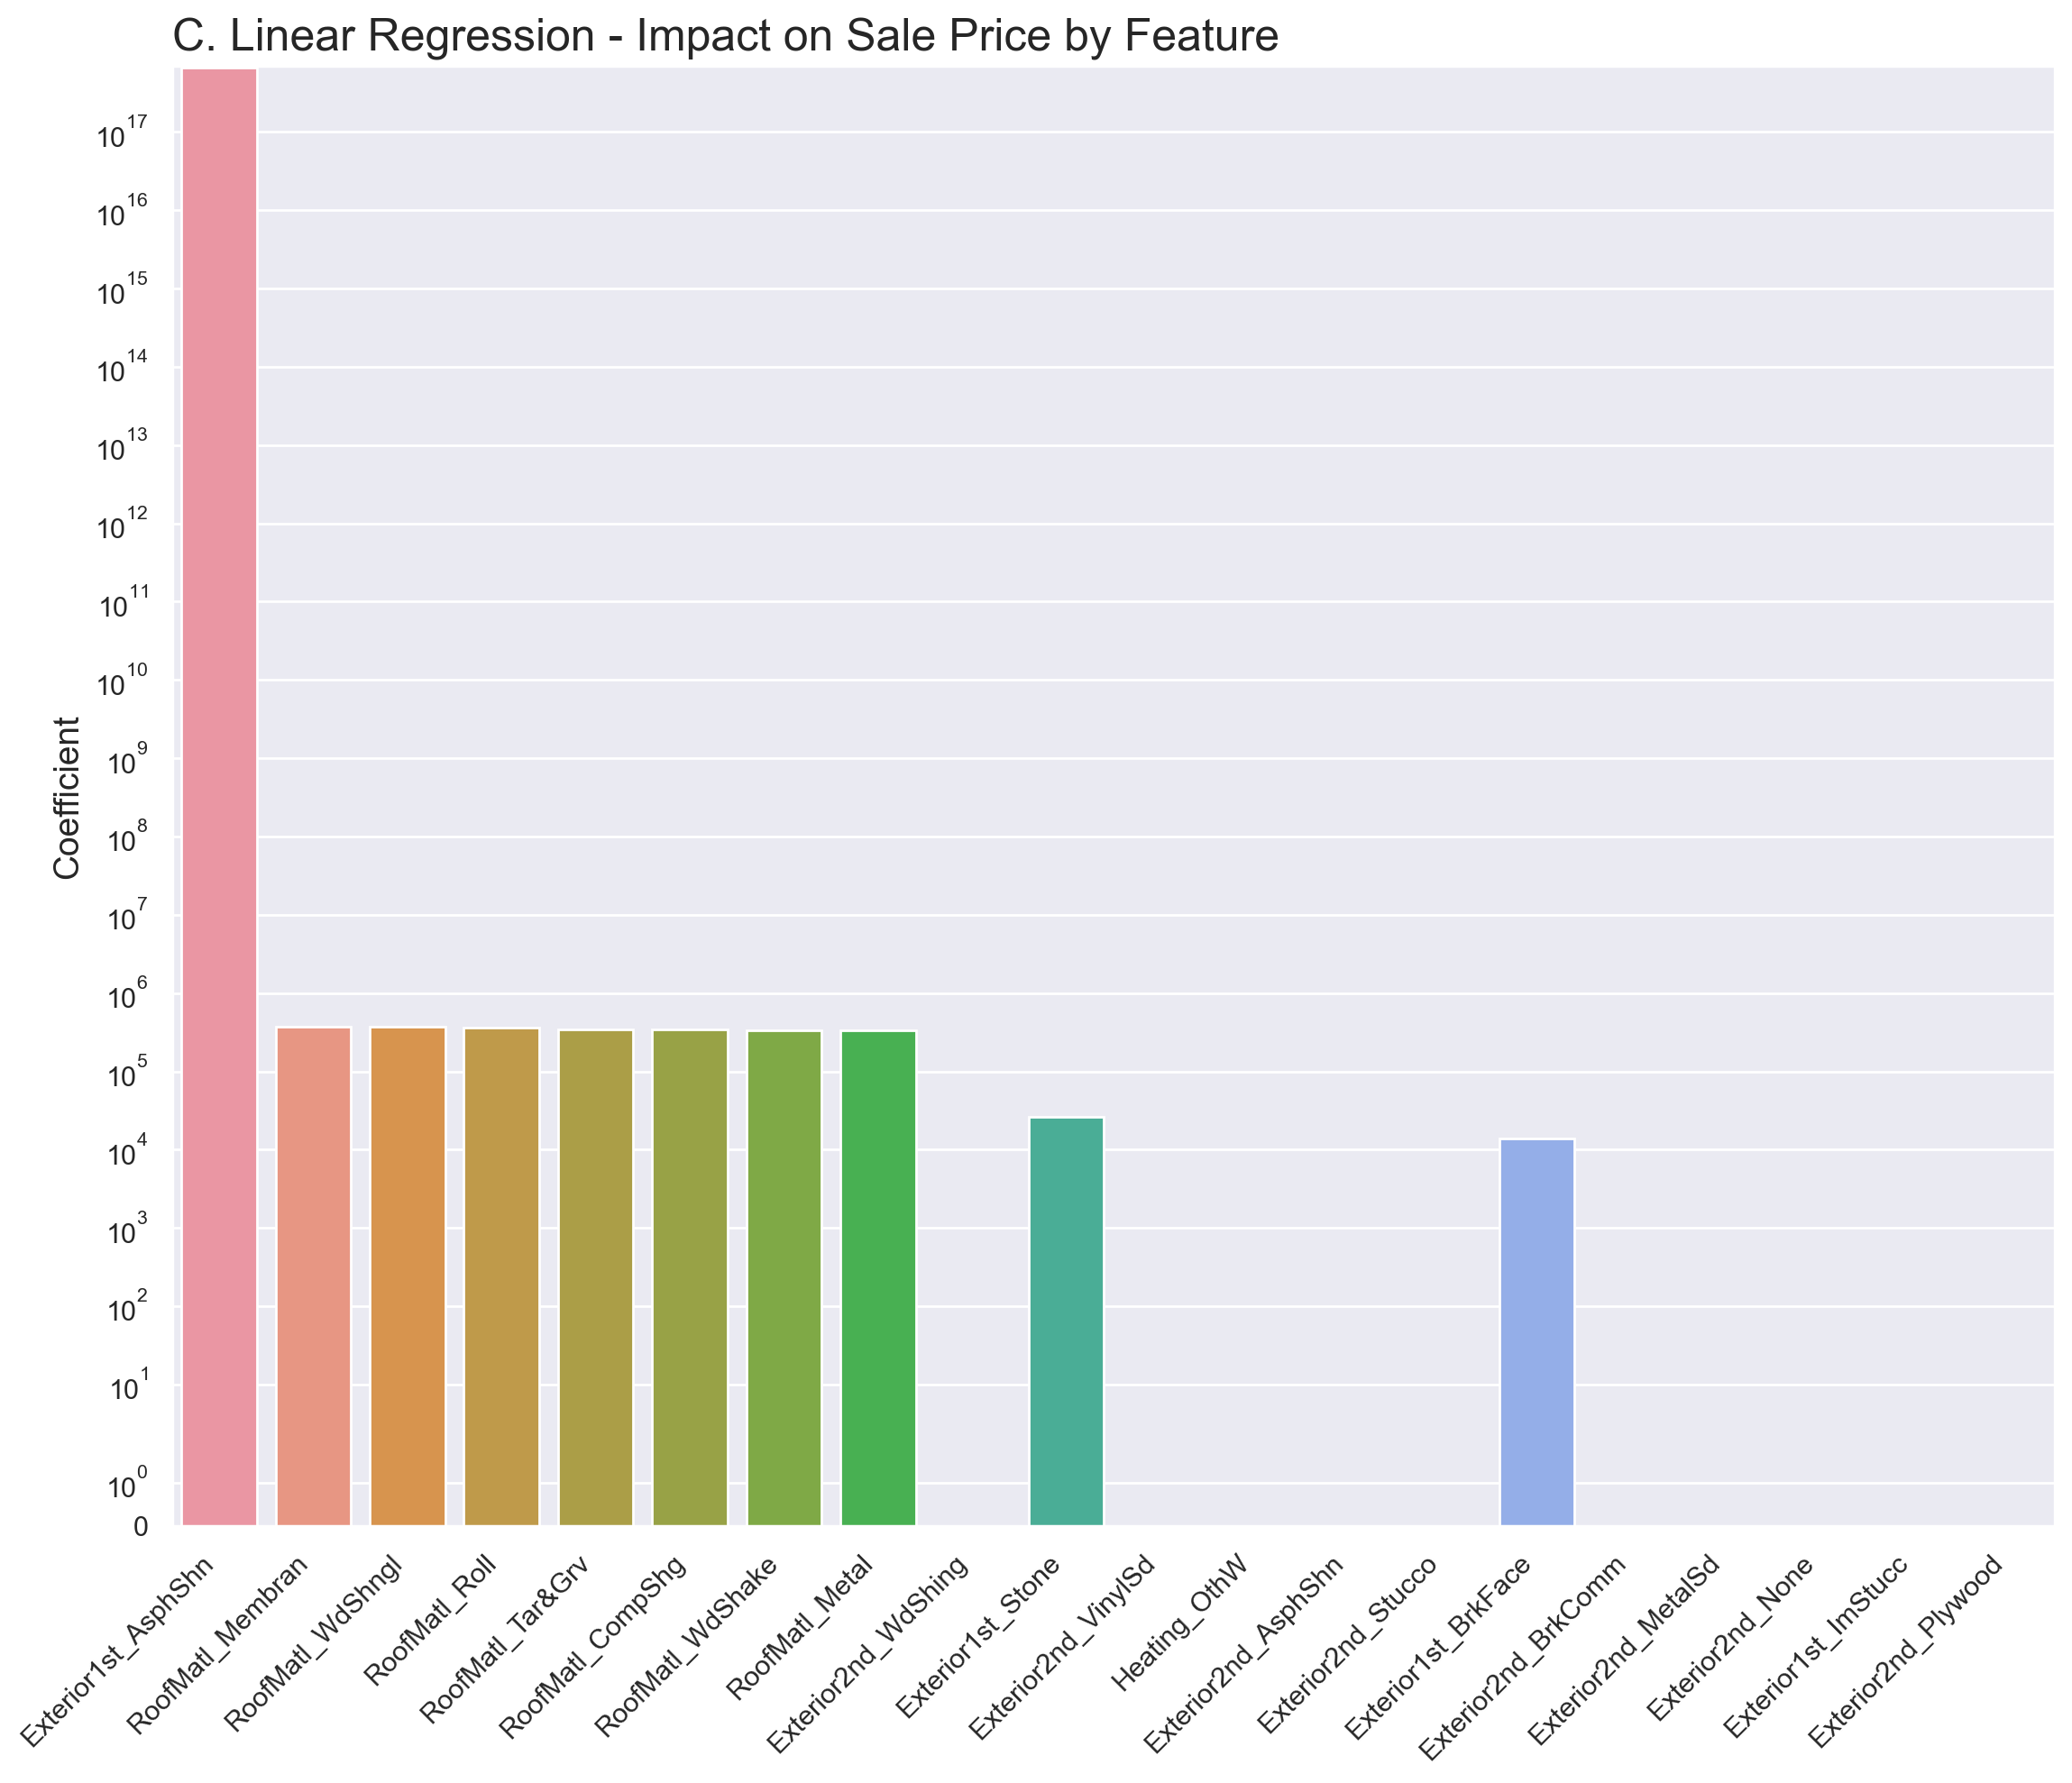

In [78]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,10))

sns.barplot(data=linreg_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('C. Linear Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.yscale('symlog')

plt.show()

### Lasso Regression with LassoCV

In [79]:
# instantiate a LassoCV model
opt_lasso = LassoCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_lasso.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_lasso.alpha_)

Optimal Alpha: 258.2618760682677


In [80]:
# instantiate the model
lasso = Lasso(alpha=opt_lasso.alpha_)

# fit the model
lasso.fit(X_train, y_train)

# calculate the scores
c_lasso_train = lasso.score(X_train, y_train)
c_lasso_test = lasso.score(X_test, y_test)
c_lasso_cv = (cross_val_score(lasso, X_train, y_train, cv = 10)).mean()

c_lasso_predictions_train = lasso.predict(X_train)
c_lasso_predictions = lasso.predict(X_test)

c_lasso_MSE = metrics.mean_squared_error(y_test, c_lasso_predictions)
c_lasso_MAE = metrics.mean_absolute_error(y_test, c_lasso_predictions)

# collect the scores in a dataframe to compare different models later
c_lasso_df = pd.DataFrame([{'train': c_lasso_train,
                            'test' : c_lasso_test,
                            'CV'   : c_lasso_cv,
                            'MSE'  : c_lasso_MSE,
                            'MAE'  : c_lasso_MAE}],
                            index = ['C. Lasso Regression'])

# score the model
print('C. Lasso Regression Scores: \n')
print('R-squared train score: ', c_lasso_train)
print('R-squared test score:  ', c_lasso_test)
print('R-squared CV score:    ', c_lasso_cv)
print('Mean Squared Error:    ', c_lasso_MSE)
print('Mean Absolute Error:   ', c_lasso_MAE)

C. Lasso Regression Scores: 

R-squared train score:  0.1346269635844387
R-squared test score:   0.10890072661169448
R-squared CV score:     0.12207446513776796
Mean Squared Error:     445638818.836052
Mean Absolute Error:    16024.84767513256


In [81]:
# display the model intercept
print('Intercept:', lasso.intercept_)

Intercept: -62203.509486599854


In [82]:
# collect the model coefficients in a dataframe
lasso_coef = pd.DataFrame(list(zip(X_train.columns, lasso.coef_)), columns = ['variable','coefficient'])
lasso_coef['coef_abs'] = abs(lasso_coef['coefficient'])

# display the largest model coefficients
lasso_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable   coefficient      coef_abs
27  Exterior1st_BrkFace  11543.371640  11543.371640
64     Electrical_SBrkr  -4894.770205   4894.770205
0           OverallQual   4643.017094   4643.017094
1           OverallCond   4020.487048   4020.487048
10           Functional   2649.159891   2649.159891
30  Exterior1st_HdBoard  -2377.391414   2377.391414
6             BsmtUnfSF  -1674.605689   1674.605689
29  Exterior1st_CemntBd   1662.087972   1662.087972
3             ExterCond   -707.808052    707.808052
13           GarageQual   -562.605627    562.605627
15                Fence   -526.621195    526.621195
5          BsmtFinType2   -461.454074    461.454074
2            MasVnrArea   -172.590544    172.590544
4          BsmtFinType1     42.239412     42.239412
11          FireplaceQu     -6.855531      6.855531
44  Exterior2nd_MetalSd     -0.000000      0.000000
50  Exterior2nd_VinylSd     -0.000000      0.000000
45     Exterior2nd_None      0.000000      0.000000
43  Exterior2nd_ImStucc      0.000000      0.000000
46    Exterior2nd_Other      0.000000      0.000000

In [83]:
# display the coefficients which has been reduced to 0
lasso_zeroed = lasso_coef[lasso_coef['coefficient'] == 0].shape[0]
print('Lasso Regression has zeroed',lasso_zeroed , 'coefficients.')
list(lasso_coef['variable'][lasso_coef['coefficient'] == 0].values)

Lasso Regression has zeroed 50 coefficients.


['HeatingQC',
 'CentralAir',
 'LowQualFinSF',
 'GarageFinish',
 'PavedDrive',
 'Alley_None',
 'Alley_Pave',
 'RoofMatl_CompShg',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_Tar&Grv',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_ImStucc',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior1st_Stone',
 'Exterior1st_Stucco',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_WdShing',
 'Exterior2nd_AsphShn',
 'Exterior2nd_BrkComm',
 'Exterior2nd_BrkFace',
 'Exterior2nd_HdBoard',
 'Exterior2nd_ImStucc',
 'Exterior2nd_MetalSd',
 'Exterior2nd_None',
 'Exterior2nd_Other',
 'Exterior2nd_Plywood',
 'Exterior2nd_Stone',
 'Exterior2nd_Stucco',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_WdShing',
 'MasVnrType_BrkFace',
 'MasVnrType_None',
 'MasVnrType_Stone',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'Electrical_

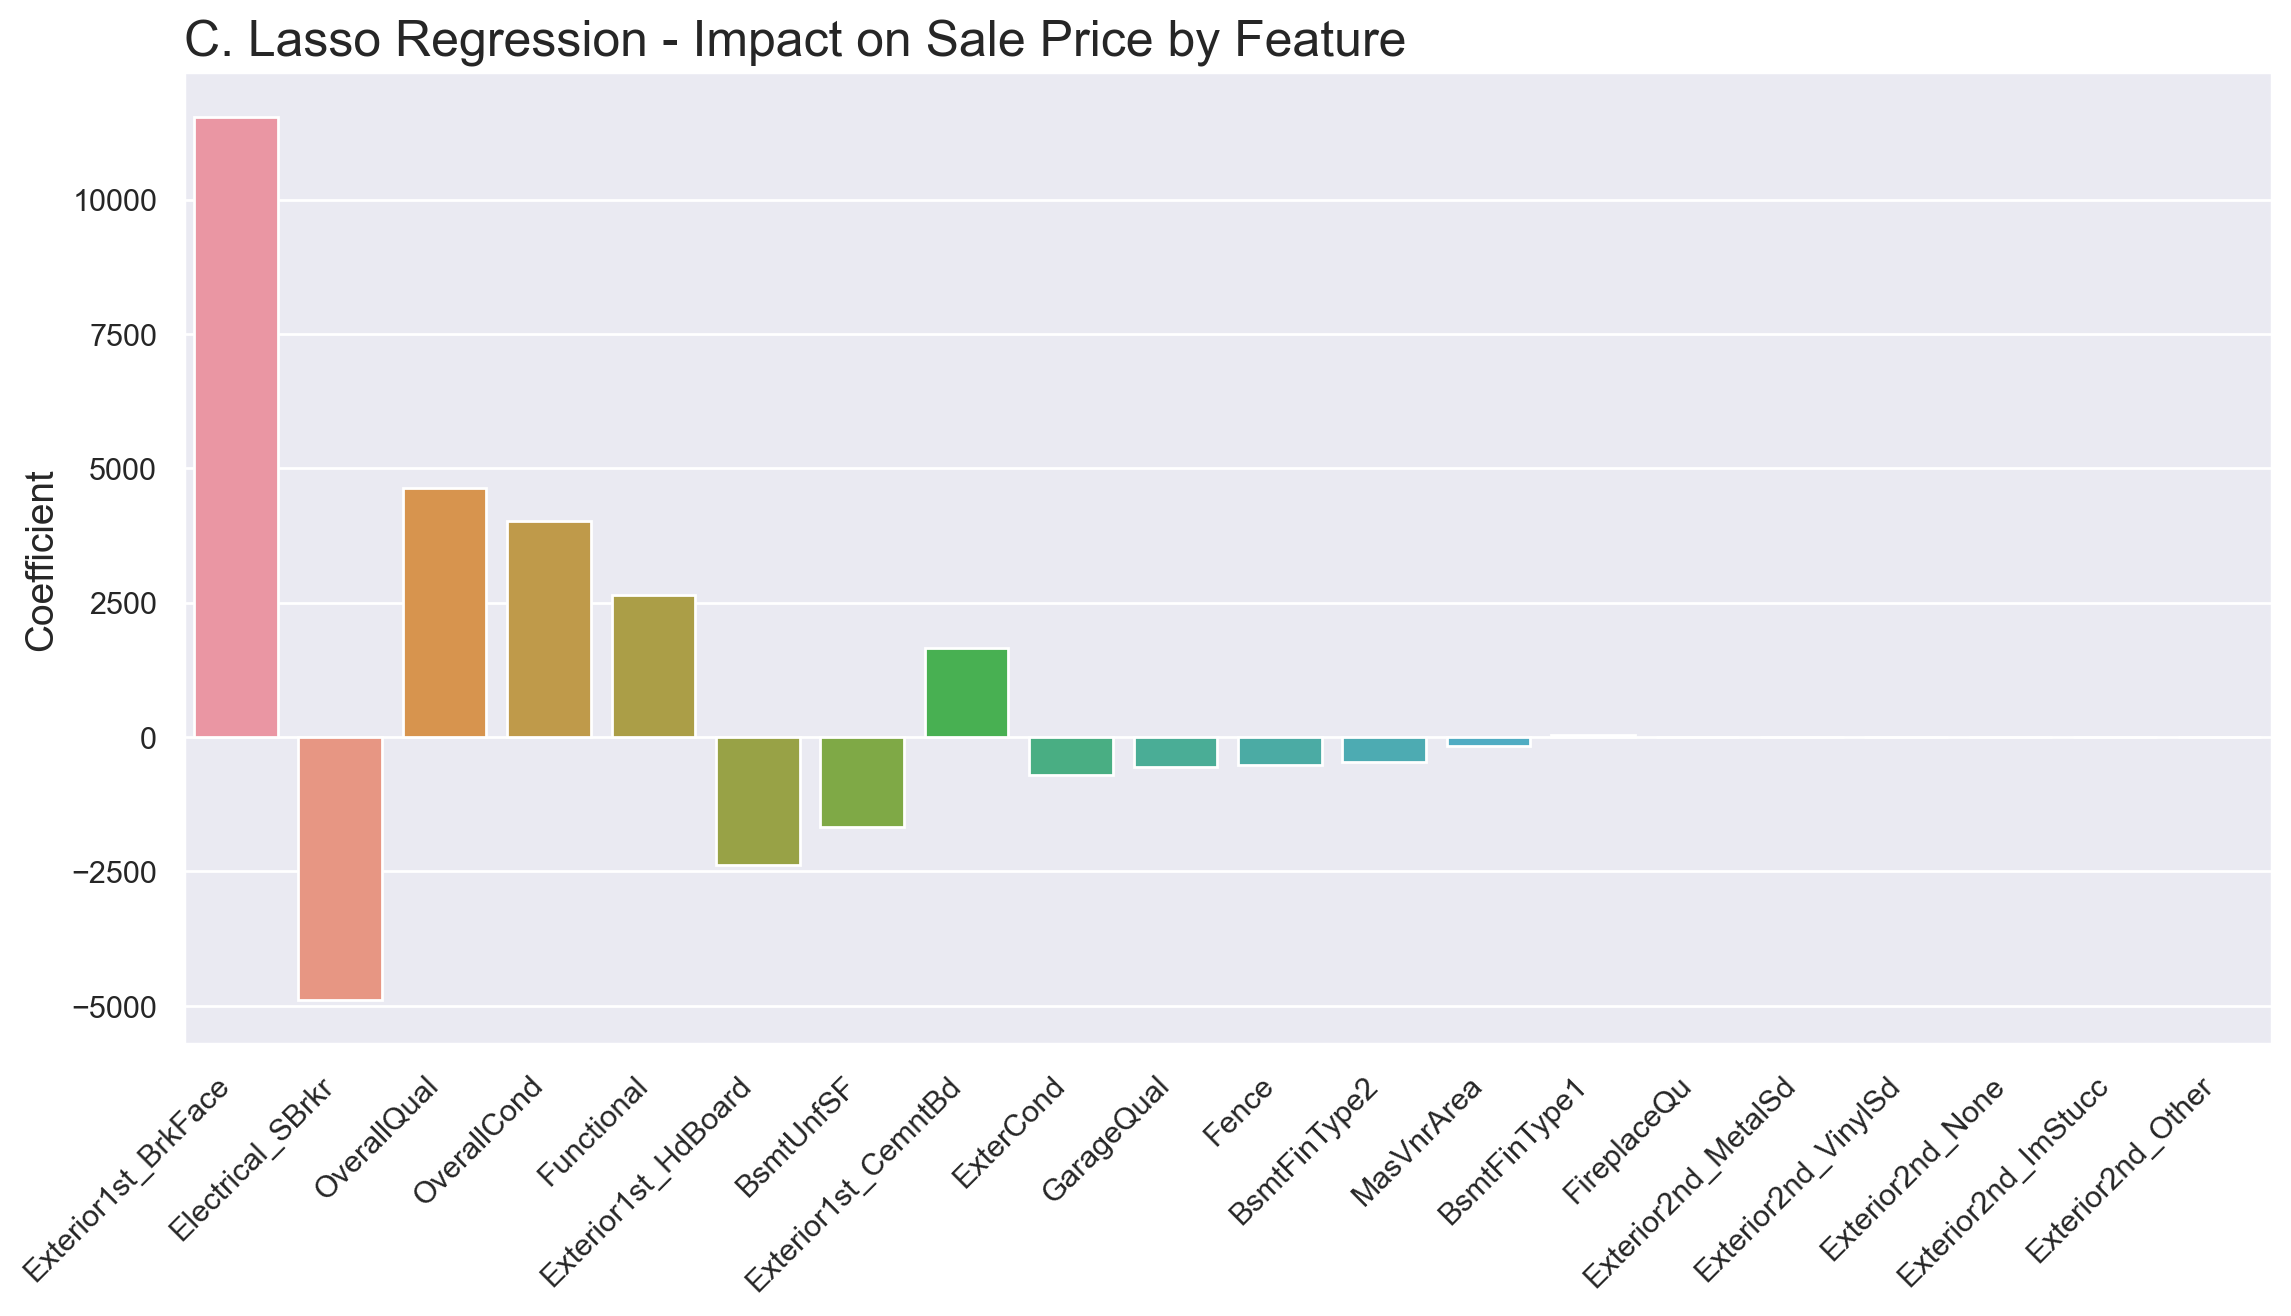

In [84]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=lasso_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('C. Lasso Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Ridge Regression with RidgeCV

In [85]:
# instantiate a RidgeCV model
opt_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_ridge.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_ridge.alpha_)

Optimal Alpha: 45.5293507486695


In [86]:
# instantiate the model
ridge = Ridge(alpha=opt_ridge.alpha_)

# fit the model
ridge.fit(X_train, y_train)

# calculate the scores
c_ridge_train = ridge.score(X_train, y_train)
c_ridge_test = ridge.score(X_test, y_test)
c_ridge_cv = (cross_val_score(ridge, X_train, y_train, cv = 10)).mean()

c_ridge_predictions_train = ridge.predict(X_train)
c_ridge_predictions = ridge.predict(X_test)

c_ridge_MSE = metrics.mean_squared_error(y_test, c_ridge_predictions)
c_ridge_MAE = metrics.mean_absolute_error(y_test, c_ridge_predictions)

# collect the scores in a dataframe to compare different models later
c_ridge_df = pd.DataFrame([{'train': c_ridge_train,
                            'test' : c_ridge_test,
                            'CV'   : c_ridge_cv,
                            'MSE'  : c_ridge_MSE,
                            'MAE'  : c_ridge_MAE}],
                            index = ['C. Ridge Regression'])

# score the model
print('C. Ridge Regression Scores: \n')
print('R-squared train score: ', c_ridge_train)
print('R-squared test score:  ', c_ridge_test)
print('R-squared CV score:    ', c_ridge_cv)
print('Mean Squared Error:    ', c_ridge_MSE)
print('Mean Absolute Error:   ', c_ridge_MAE)

C. Ridge Regression Scores: 

R-squared train score:  0.15022238161906476
R-squared test score:   0.10650596717687211
R-squared CV score:     0.11001295739677164
Mean Squared Error:     446836438.22347766
Mean Absolute Error:    15972.837365658019


In [87]:
# display the model intercept
print('Intercept:', ridge.intercept_)

Intercept: -64072.6867146245


In [88]:
# collect the model coefficients in a dataframe
ridge_coef = pd.DataFrame(list(zip(X_train.columns, ridge.coef_)), columns = ['variable','coefficient'])
ridge_coef['coef_abs'] = abs(ridge_coef['coefficient'])

# display the largest model coefficients
ridge_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable  coefficient     coef_abs
27  Exterior1st_BrkFace  8057.866565  8057.866565
64     Electrical_SBrkr -5409.281981  5409.281981
0           OverallQual  4934.178354  4934.178354
30  Exterior1st_HdBoard -4386.286904  4386.286904
1           OverallCond  4370.146293  4370.146293
52  Exterior2nd_WdShing -4012.778452  4012.778452
29  Exterior1st_CemntBd  3664.383155  3664.383155
18     RoofMatl_CompShg  3505.754726  3505.754726
35   Exterior1st_Stucco -3400.063619  3400.063619
51  Exterior2nd_Wd Sdng  2948.212176  2948.212176
10           Functional  2941.779487  2941.779487
3             ExterCond -2464.578339  2464.578339
6             BsmtUnfSF -2083.166093  2083.166093
24     RoofMatl_WdShngl  1923.240000  1923.240000
38  Exterior1st_WdShing -1868.798811  1868.798811
37  Exterior1st_Wd Sdng -1778.641599  1778.641599
53   MasVnrType_BrkFace  1601.775805  1601.775805
16           Alley_None  1465.770701  1465.770701
36  Exterior1st_VinylSd -1182.552160  1182.552160
56         Heating_GasA -1137.579058  1137.579058

In [89]:
# display the coefficients which has been reduced to 0
ridge_zeroed = ridge_coef[ridge_coef['coefficient'] == 0].shape[0]
print('Ridge Regression has zeroed',ridge_zeroed , 'coefficients.')
list(ridge_coef['variable'][ridge_coef['coefficient'] == 0].values)

Ridge Regression has zeroed 1 coefficients.


['Exterior1st_AsphShn']

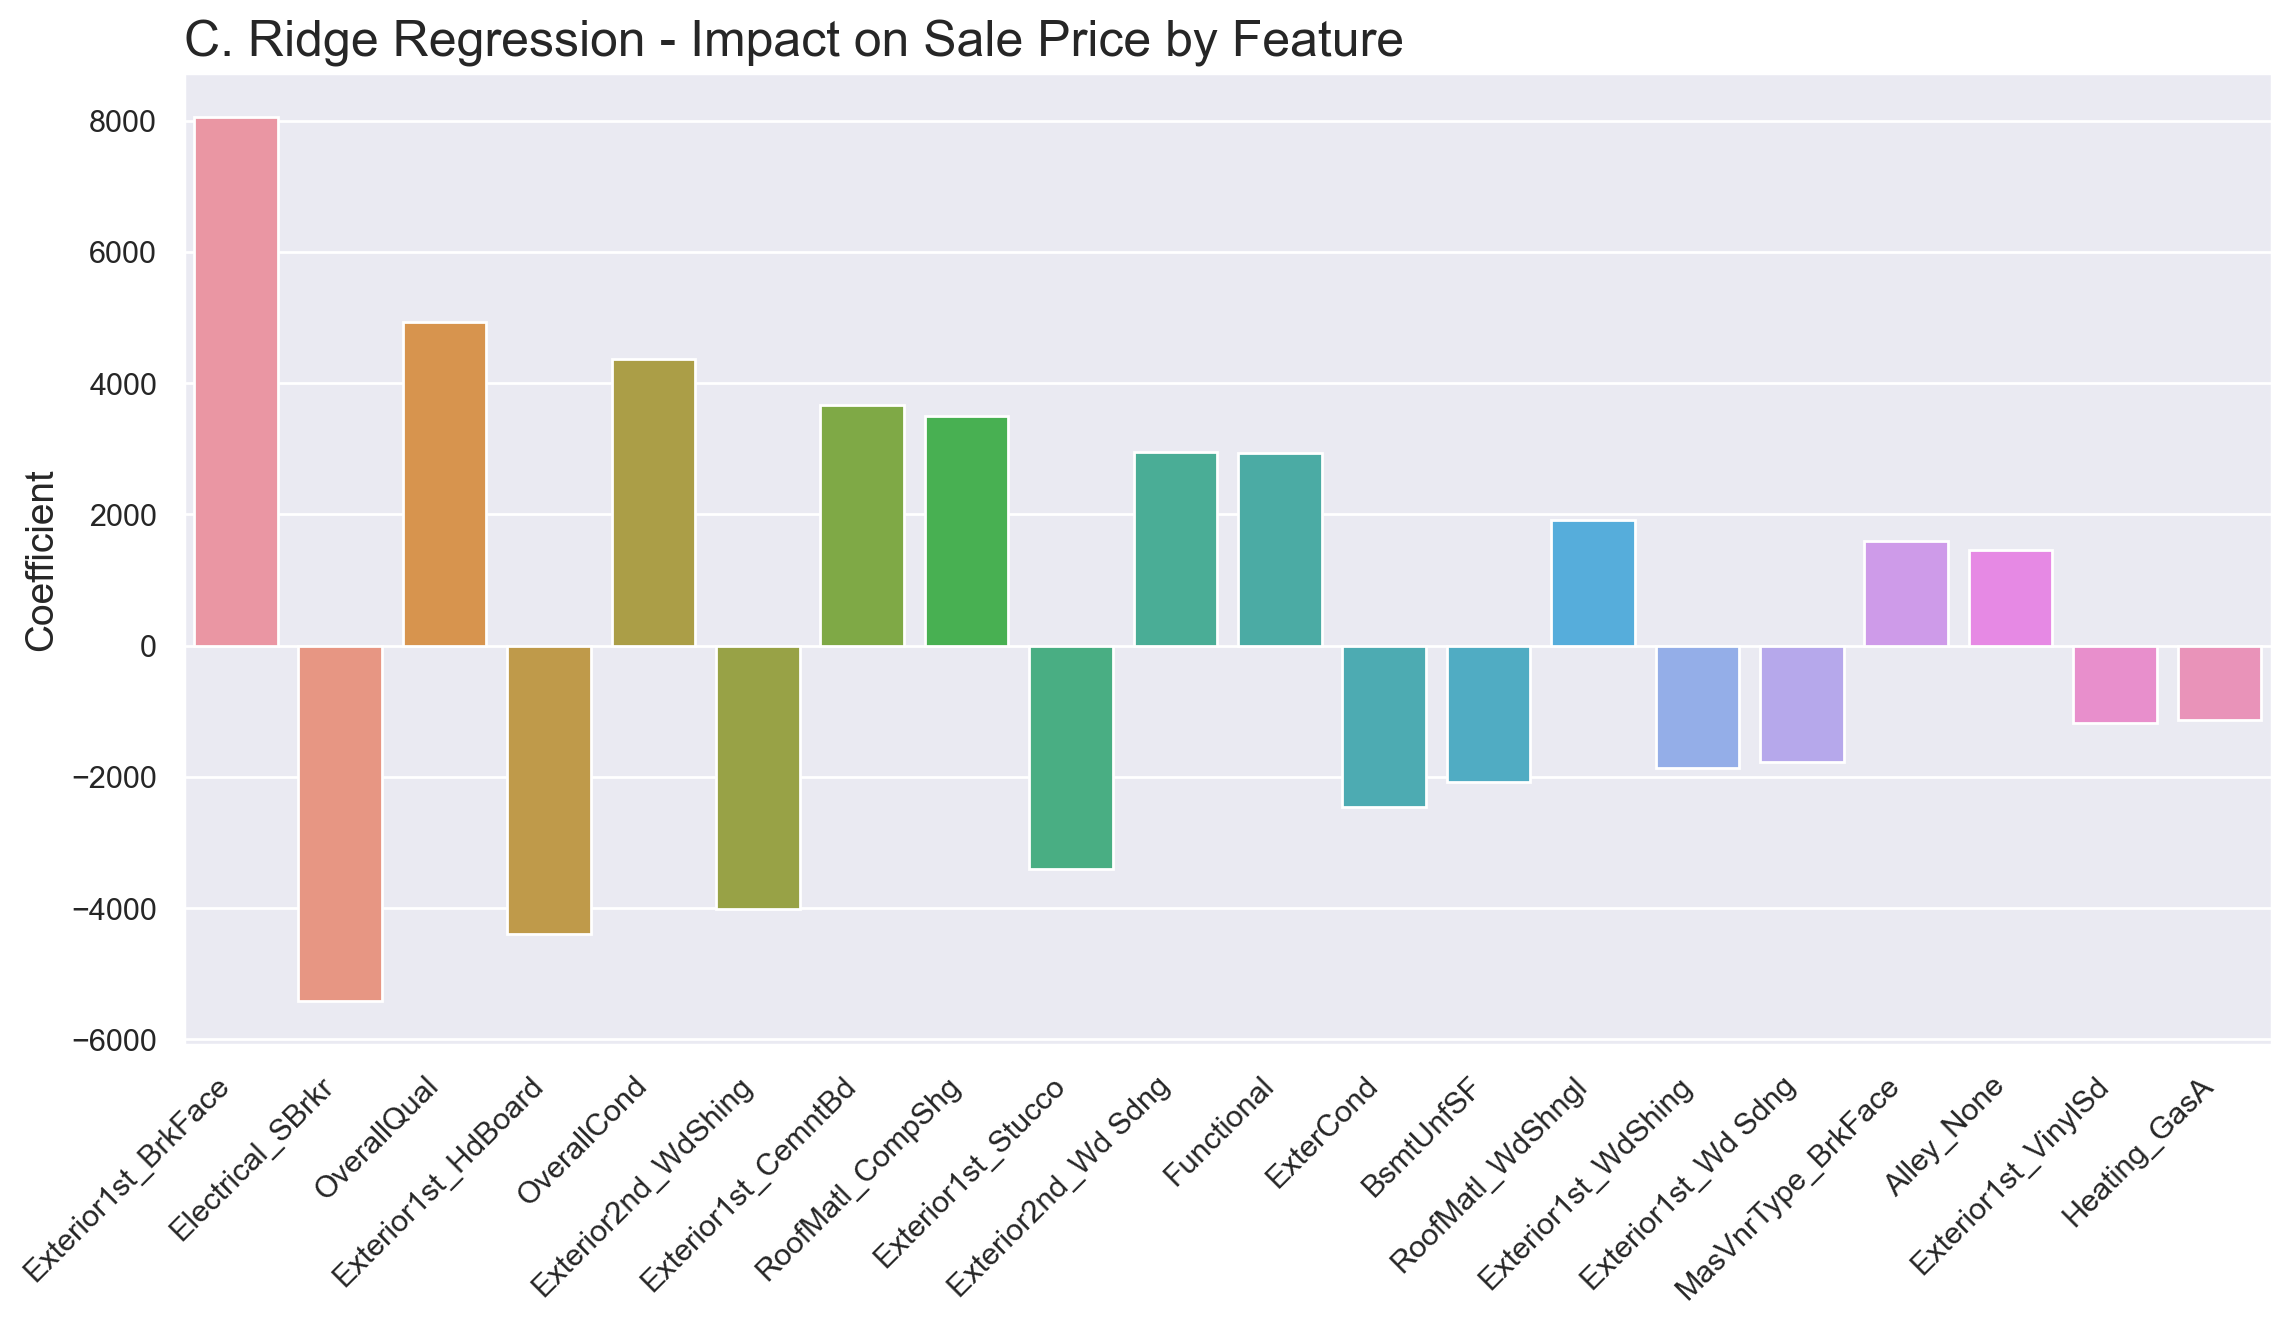

In [90]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=ridge_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('C. Ridge Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Elastic Net Regression with ElasticNetCV

In [91]:
# instantiate a ElasticnetCV model
opt_enet = ElasticNetCV(alphas=np.logspace(-4, 4, 10), l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                        max_iter = 100000, cv=10)

# fit the model
opt_enet.fit(X_train, y_train)

# display the optimal alpha and L1 ratio
print('Optimal Alpha:', opt_enet.alpha_)
print('Optimal L1 ratio:', opt_enet.l1_ratio_)

Optimal Alpha: 166.81005372000558
Optimal L1 ratio: 1.0


In [92]:
# instantiate the model
enet = ElasticNet(alpha=opt_enet.alpha_, l1_ratio=opt_enet.l1_ratio_)

# fit the model
enet.fit(X_train, y_train)

# calculate the scores
c_enet_train = enet.score(X_train, y_train)
c_enet_test = enet.score(X_test, y_test)
c_enet_cv = (cross_val_score(enet, X_train, y_train, cv = 10)).mean()

c_enet_predictions_train = enet.predict(X_train)
c_enet_predictions = enet.predict(X_test)

c_enet_MSE = metrics.mean_squared_error(y_test, c_enet_predictions)
c_enet_MAE = metrics.mean_absolute_error(y_test, c_enet_predictions)

# collect the scores in a dataframe to compare different models later
c_enet_df = pd.DataFrame([{'train': c_enet_train,
                           'test' : c_enet_test,
                           'CV'   : c_enet_cv,
                           'MSE'  : c_enet_MSE,
                           'MAE'  : c_enet_MAE}],
                           index = ['C. Elastic Net Regression'])

# score the model
print('C. Elastic Net Regression Scores: \n')
print('R-squared train score: ', c_enet_train)
print('R-squared test score:  ', c_enet_test)
print('R-squared CV score:    ', c_enet_cv)
print('Mean Squared Error:    ', c_enet_MSE)
print('Mean Absolute Error:   ', c_enet_MAE)

C. Elastic Net Regression Scores: 

R-squared train score:  0.14562713843384156
R-squared test score:   0.11220372033005199
R-squared CV score:     0.11941204628220521
Mean Squared Error:     443986991.40982723
Mean Absolute Error:    15999.782287046524


In [93]:
# display the model intercept
print('Intercept:', enet.intercept_)

Intercept: -63515.08392748307


In [94]:
# collect the model coefficients in a dataframe
enet_coef = pd.DataFrame(list(zip(X_train.columns, enet.coef_)), columns = ['variable','coefficient'])
enet_coef['coef_abs'] = abs(enet_coef['coefficient'])

# display the largest model coefficients
enet_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

variable   coefficient      coef_abs
27  Exterior1st_BrkFace  14761.797765  14761.797765
64     Electrical_SBrkr  -5797.437088   5797.437088
0           OverallQual   4824.643172   4824.643172
29  Exterior1st_CemntBd   4377.178906   4377.178906
1           OverallCond   4194.518065   4194.518065
52  Exterior2nd_WdShing  -3444.796139   3444.796139
30  Exterior1st_HdBoard  -3016.382500   3016.382500
10           Functional   2865.402557   2865.402557
6             BsmtUnfSF  -1892.303657   1892.303657
3             ExterCond  -1592.888678   1592.888678
53   MasVnrType_BrkFace   1011.413581   1011.413581
18     RoofMatl_CompShg   1005.700469   1005.700469
13           GarageQual   -664.602461    664.602461
15                Fence   -552.631300    552.631300
5          BsmtFinType2   -540.801894    540.801894
2            MasVnrArea   -482.870365    482.870365
7             HeatingQC     84.957834     84.957834
11          FireplaceQu    -80.591620     80.591620
9          LowQualFinSF     73.196448     73.196448
4          BsmtFinType1     25.470819     25.470819

In [95]:
# display the coefficients which has been reduced to 0
enet_zeroed = enet_coef[enet_coef['coefficient'] == 0].shape[0]
print('Elastic Net Regression has zeroed',enet_zeroed , 'coefficients.')
list(enet_coef['variable'][enet_coef['coefficient'] == 0].values)

Elastic Net Regression has zeroed 45 coefficients.


['CentralAir',
 'GarageFinish',
 'PavedDrive',
 'Alley_None',
 'Alley_Pave',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_Tar&Grv',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_ImStucc',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior1st_Stone',
 'Exterior1st_Stucco',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_WdShing',
 'Exterior2nd_AsphShn',
 'Exterior2nd_BrkComm',
 'Exterior2nd_BrkFace',
 'Exterior2nd_HdBoard',
 'Exterior2nd_ImStucc',
 'Exterior2nd_MetalSd',
 'Exterior2nd_None',
 'Exterior2nd_Other',
 'Exterior2nd_Plywood',
 'Exterior2nd_Stone',
 'Exterior2nd_Stucco',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'MasVnrType_None',
 'MasVnrType_Stone',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'Electrical_FuseF',
 'Electrical_FuseP',
 'Electrical_Mix']

In [96]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=enet_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('C. Elastic Net Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Model Set Score Evaluation

In [97]:
C_models = pd.concat([c_linreg_df, c_lasso_df, c_ridge_df, c_enet_df], axis = 0)
C_models.round(decimals=5)

train          test            CV           MSE  \
C. Linear Regression       0.32686 -5.385559e+24 -2.990882e+23  2.693319e+33   
C. Lasso Regression        0.13463  1.089000e-01  1.220700e-01  4.456388e+08   
C. Ridge Regression        0.15022  1.065100e-01  1.100100e-01  4.468364e+08   
C. Elastic Net Regression  0.14563  1.122000e-01  1.194100e-01  4.439870e+08   

                                    MAE  
C. Linear Regression       4.040191e+15  
C. Lasso Regression        1.602485e+04  
C. Ridge Regression        1.597284e+04  
C. Elastic Net Regression  1.599978e+04

In [98]:
### COMMENTS



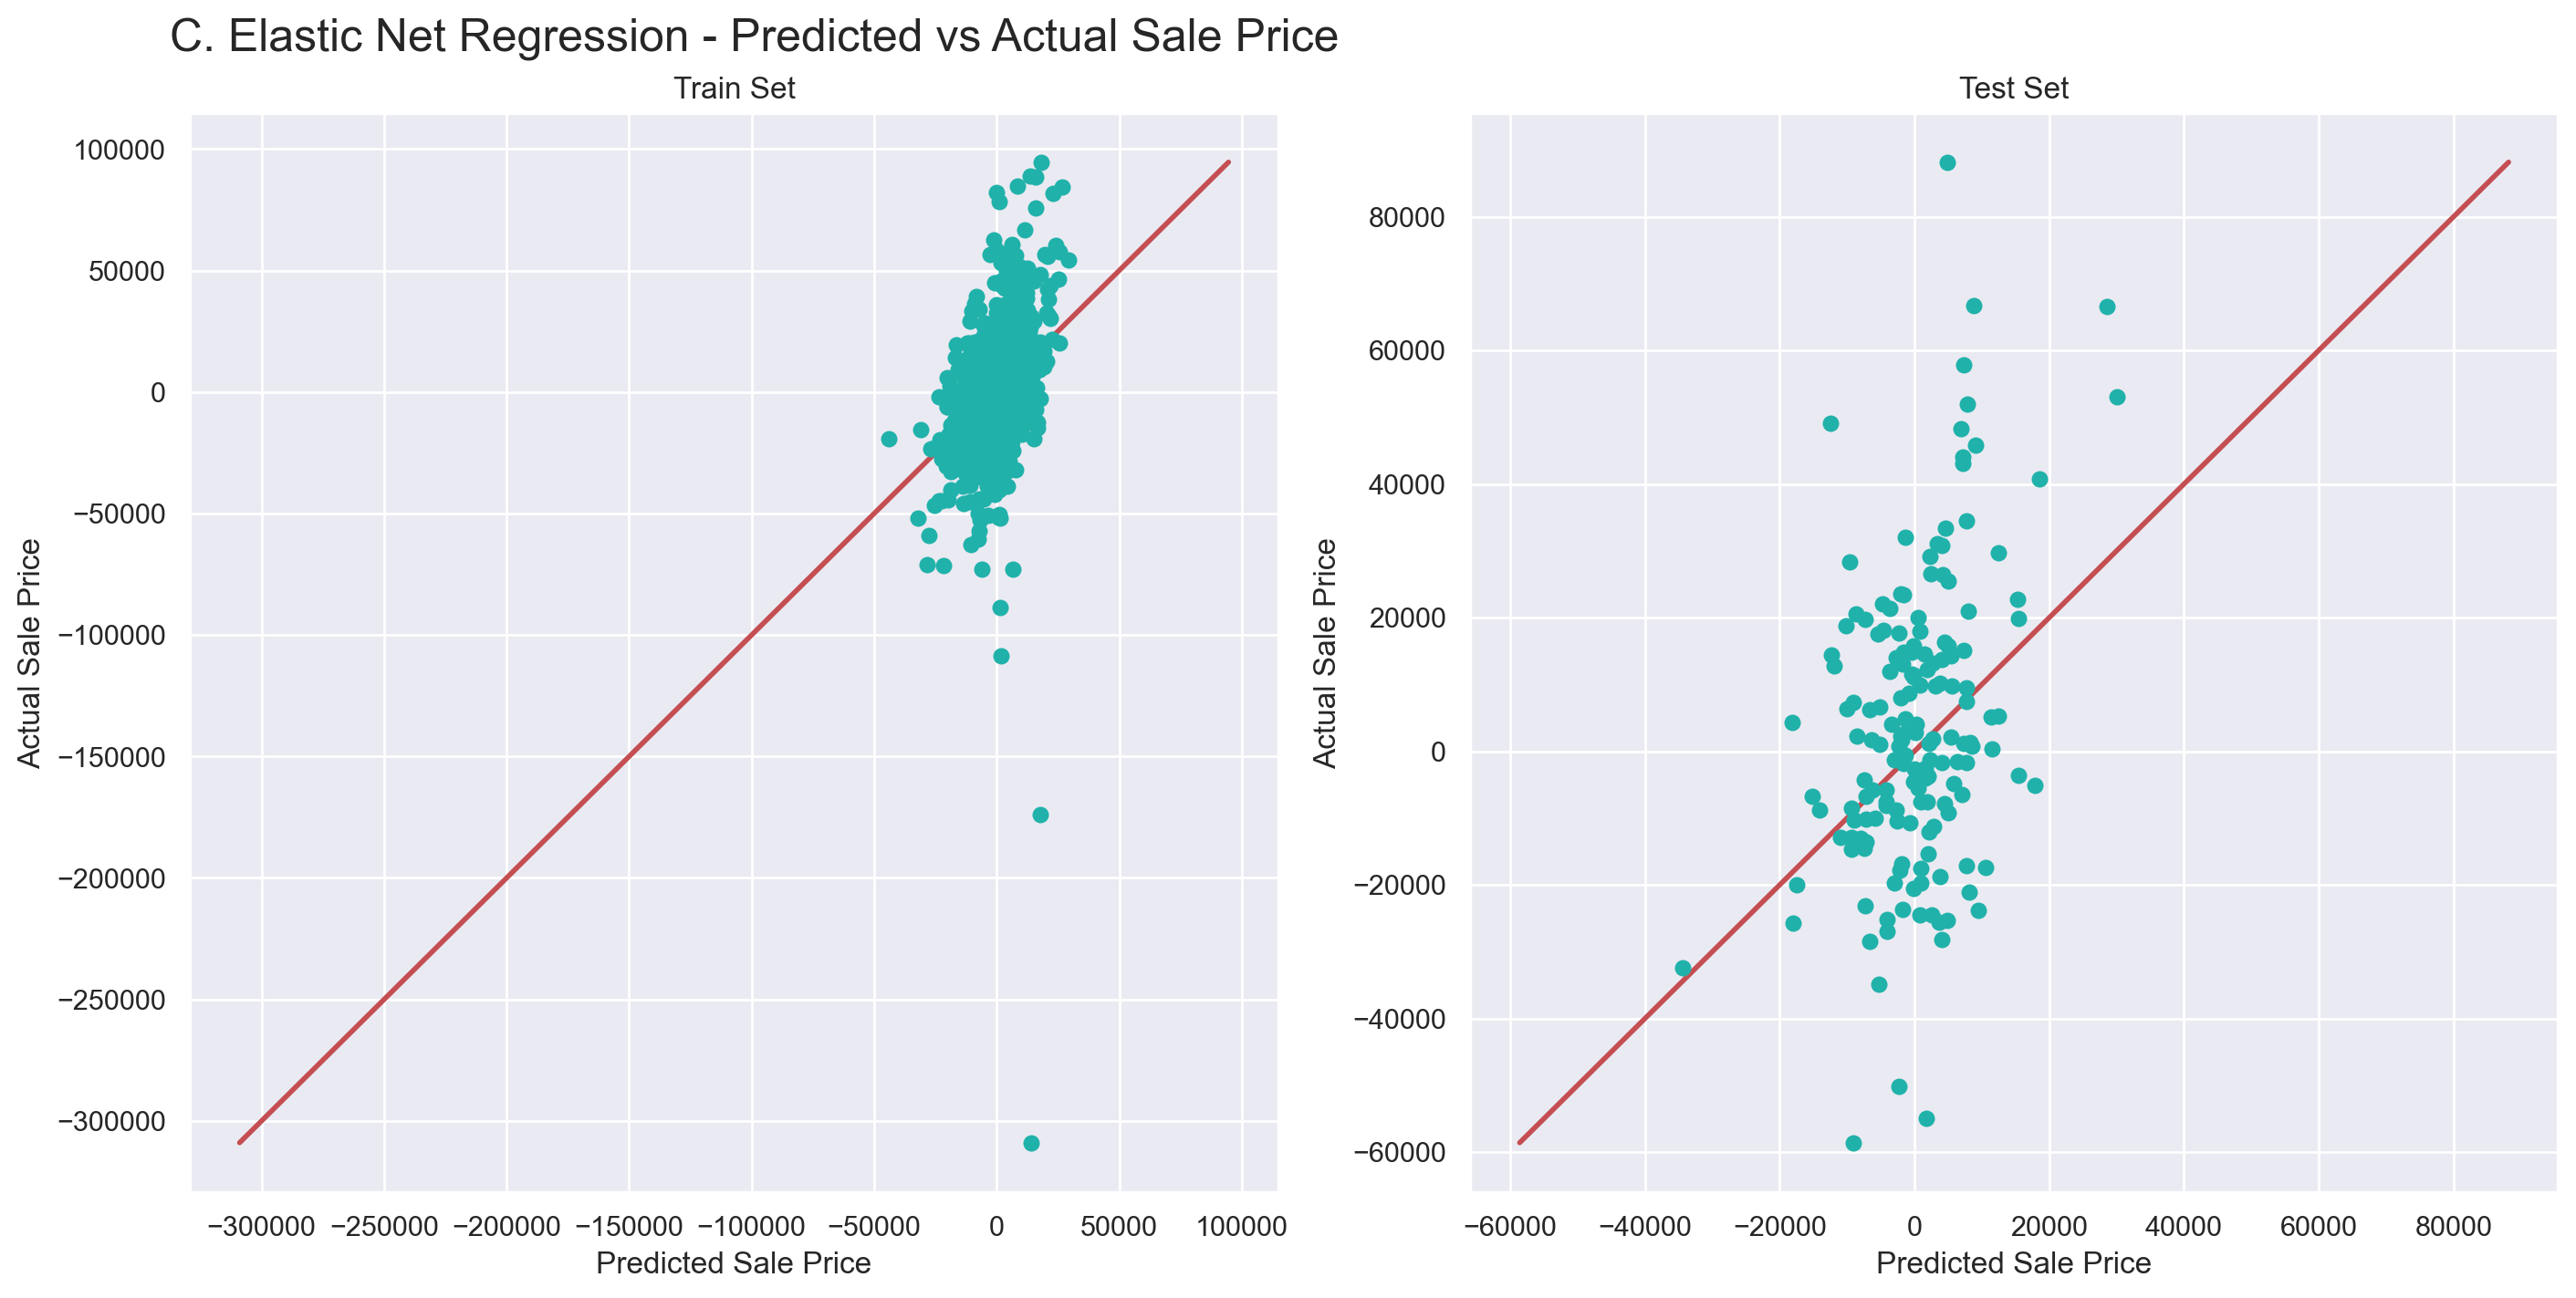

In [99]:
# plot the predicted y values against the actual y values by the elastic net method
fig, ax = plt.subplots(ncols=2, figsize=(14, 7), constrained_layout=True)

fig.suptitle('C. Elastic Net Regression - Predicted vs Actual Sale Price', x=0.52, horizontalalignment='right', fontsize=18)

ax[0].scatter(c_enet_predictions_train, y_train, s=30, color = 'lightseagreen', zorder=10)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r', lw=2)
ax[0].set_ylabel('Actual Sale Price')
ax[0].set_xlabel('Predicted Sale Price')
ax[0].set_title('Train Set')

ax[1].scatter(c_enet_predictions, y_test, s=30, color='lightseagreen', zorder=10)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r', lw=2)
ax[1].set_ylabel('Actual Sale Price')
ax[1].set_xlabel('Predicted Sale Price')
ax[1].set_title('Test Set')

plt.show()

In [100]:
### CONCLUSIONS




### Regression Score Evaluation

In [101]:
rgr_models = pd.concat([a_linreg_df, a_lasso_df, a_ridge_df, a_enet_df,
                        b_linreg_df, b_lasso_df, b_ridge_df, b_enet_df,
                        c_linreg_df, c_lasso_df, c_ridge_df, c_enet_df], axis = 0)

rgr_models.round(decimals=5)

train          test            CV           MSE  \
A. Linear Regression       0.84435 -5.340567e+23 -2.351305e+23  1.854422e+33   
A. Lasso Regression        0.82640  8.516000e-01  7.693200e-01  5.153047e+08   
A. Ridge Regression        0.83282  8.518900e-01  7.688600e-01  5.142837e+08   
A. Elastic Net Regression  0.83391  8.519800e-01  7.686500e-01  5.139693e+08   
B. Linear Regression       0.73410 -6.784485e+24 -2.377302e+23  2.355799e+34   
B. Lasso Regression        0.72327  6.990900e-01  6.961400e-01  1.044850e+09   
B. Ridge Regression        0.71776  6.937700e-01  6.990000e-01  1.063329e+09   
B. Elastic Net Regression  0.71871  6.948400e-01  6.989300e-01  1.059607e+09   
C. Linear Regression       0.32686 -5.385559e+24 -2.990882e+23  2.693319e+33   
C. Lasso Regression        0.13463  1.089000e-01  1.220700e-01  4.456388e+08   
C. Ridge Regression        0.15022  1.065100e-01  1.100100e-01  4.468364e+08   
C. Elastic Net Regression  0.14563  1.122000e-01  1.194100e-01  4.439870e+08   

                                    MAE  
A. Linear Regression       3.352450e+15  
A. Lasso Regression        1.673720e+04  
A. Ridge Regression        1.685069e+04  
A. Elastic Net Regression  1.687986e+04  
B. Linear Regression       1.194888e+16  
B. Lasso Regression        2.431517e+04  
B. Ridge Regression        2.457849e+04  
B. Elastic Net Regression  2.453562e+04  
C. Linear Regression       4.040191e+15  
C. Lasso Regression        1.602485e+04  
C. Ridge Regression        1.597284e+04  
C. Elastic Net Regression  1.599978e+04

In [ ]:
### CONCLUSIONS


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [102]:
# check the columns shared by both dataframes (fixed and mutable features)
for x in df_f.columns:
    if x in df_m.columns:
        print(x)

YrSold
SalePrice


In [103]:
# remove the columns from one dataframe
df_m = df_m.drop(['YrSold', 'SalePrice'], axis = 1)

In [104]:
# merge the dataframes
df = pd.concat([df_f, df_m], axis = 1)

print(df.shape)
df.head()

(1379, 57)


MSZoning  LotFrontage  LotArea LotShape LandContour LotConfig  LandSlope  \
0       RL         65.0   8450.0      Reg         Lvl    Inside          3   
1       RL         80.0   9600.0      Reg         Lvl       FR2          3   
2       RL         68.0  11250.0      IR1         Lvl    Inside          3   
3       RL         60.0   9550.0      IR1         Lvl    Corner          3   
4       RL         84.0  14260.0      IR1         Lvl       FR2          3   

  Neighborhood Condition1 Condition2 BldgType HouseStyle  YearRemodAdd  \
0      CollgCr       Norm       None     1Fam     2Story        2003.0   
1      Veenker      Feedr       Norm     1Fam     1Story        1976.0   
2      CollgCr       Norm       None     1Fam     2Story        2002.0   
3      Crawfor       Norm       None     1Fam     2Story        1970.0   
4      NoRidge       Norm       None     1Fam     2Story        2000.0   

  RoofStyle Foundation  BsmtExposure  KitchenAbvGr  Fireplaces  GarageArea  \
0     Gable      PConc             1             1           0         548   
1     Gable     CBlock             4             1           1         460   
2     Gable      PConc             2             1           1         608   
3     Gable     BrkTil             1             1           1         642   
4     Gable      PConc             3             1           1         836   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  MiscVal  \
0           0           61              0          0            0        0   
1         298            0              0          0            0        0   
2           0           42              0          0            0        0   
3           0           35            272          0            0        0   
4         192           84              0          0            0        0   

   MoSold  YrSold SaleType SaleCondition  SalePrice  TotalSF  FloorAreaRatio  \
0       2    2008       WD        Normal     208500   2566.0        0.202367   
1       5    2007       WD        Normal     181500   2524.0        0.131458   
2       9    2008       WD        Normal     223500   2706.0        0.158756   
3       2    2006       WD       Abnorml     140000   2473.0        0.179791   
4      12    2008       WD        Normal     250000   3343.0        0.154137   

   TotalBath  Age Alley  OverallQual  OverallCond RoofMatl Exterior1st  \
0        3.5    5  None            7            5  CompShg     VinylSd   
1        2.5   31  None            6            8  CompShg     MetalSd   
2        3.5    7  None            7            5  CompShg     VinylSd   
3        2.0   91  None            7            5  CompShg     Wd Sdng   
4        3.5    8  None            8            5  CompShg     VinylSd   

  Exterior2nd MasVnrType  MasVnrArea  ExterCond  BsmtFinType1  BsmtFinType2  \
0        None    BrkFace       196.0          3             6             1   
1        None       None         0.0          3             5             1   
2        None    BrkFace       162.0          3             6             1   
3     WdShing       None         0.0          3             5             1   
4        None    BrkFace       350.0          3             6             1   

   BsmtUnfSF Heating  HeatingQC  CentralAir Electrical  LowQualFinSF  \
0        150    GasA          5           1      SBrkr             0   
1        284    GasA          5           1      SBrkr             0   
2        434    GasA          5           1      SBrkr             0   
3        540    GasA          4           1      SBrkr             0   
4        490    GasA          5           1      SBrkr             0   

   Functional  FireplaceQu  GarageFinish  GarageQual  PavedDrive  Fence  
0           8            0             2           3           3      0  
1           8            3             2           3           3      0  
2           8            3             2           3           3      0  
3           8       

In [105]:
# check SaleType values
df.SaleType.value_counts(normalize=True)

WD       0.887600
New      0.064540
COD      0.029732
ConLD    0.005076
ConLw    0.003626
ConLI    0.002901
CWD      0.002901
Oth      0.002175
Con      0.001450
Name: SaleType, dtype: float64

In [106]:
# check SaleCondition values
df.SaleCondition.value_counts(normalize=True)

Normal     0.840464
Abnorml    0.068891
Partial    0.066715
Family     0.014503
Alloca     0.006526
AdjLand    0.002901
Name: SaleCondition, dtype: float64

In [107]:
# binarise the target variable using 1 for Abnormal and 0 for everything else
y_binary = [1 if value == 'Abnorml' else 0 for value in df.SaleCondition]

df.drop('SaleCondition', axis = 1, inplace = True)
df['SaleCond_Abnormal'] = y_binary

In [108]:
# update variable types
ordinal_vars.append('SaleCond_Abnormal')
categ_vars.append('SaleCond_Abnormal')

In [109]:
# check SaleCondition updated values
df.SaleCond_Abnormal.value_counts(normalize=True)

0    0.931109
1    0.068891
Name: SaleCond_Abnormal, dtype: float64

In [110]:
# dummify categorical variables
df_dum = pd.get_dummies(df, columns=[x for x in df.columns if x in nominal_vars], drop_first=True)

In [111]:
df_dum.head()

LotFrontage  LotArea  LandSlope  YearRemodAdd  BsmtExposure  KitchenAbvGr  \
0         65.0   8450.0          3        2003.0             1             1   
1         80.0   9600.0          3        1976.0             4             1   
2         68.0  11250.0          3        2002.0             2             1   
3         60.0   9550.0          3        1970.0             1             1   
4         84.0  14260.0          3        2000.0             3             1   

   Fireplaces  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0           0         548           0           61              0          0   
1           1         460         298            0              0          0   
2           1         608           0           42              0          0   
3           1         642           0           35            272          0   
4           1         836         192           84              0          0   

   ScreenPorch  MiscVal  MoSold  YrSold  SalePrice  TotalSF  FloorAreaRatio  \
0            0        0       2    2008     208500   2566.0        0.202367   
1            0        0       5    2007     181500   2524.0        0.131458   
2            0        0       9    2008     223500   2706.0        0.158756   
3            0        0       2    2006     140000   2473.0        0.179791   
4            0        0      12    2008     250000   3343.0        0.154137   

   TotalBath  Age  OverallQual  OverallCond  MasVnrArea  ExterCond  \
0        3.5    5            7            5       196.0          3   
1        2.5   31            6            8         0.0          3   
2        3.5    7            7            5       162.0          3   
3        2.0   91            7            5         0.0          3   
4        3.5    8            8            5       350.0          3   

   BsmtFinType1  BsmtFinType2  BsmtUnfSF  HeatingQC  CentralAir  LowQualFinSF  \
0             6             1        150          5           1             0   
1             5             1        284          5           1             0   
2             6             1        434          5           1             0   
3             5             1        540          4           1             0   
4             6             1        490          5           1             0   

   Functional  FireplaceQu  GarageFinish  GarageQual  PavedDrive  Fence  \
0           8            0             2           3           3      0   
1           8            3             2           3           3      0   
2           8            3             2           3           3      0   
3           8            4             1           3           3      0   
4           8            3             2           3           3      0   

   SaleCond_Abnormal  MSZoning_RH  MSZoning_RL  MSZoning_RM  LotShape_IR2  \
0                  0            0            1            0             0   
1                  0            0            1            0             0   
2                  0            0            1            0             0   
3                  1            0            1            0             0   
4                  0            0            1            0             0   

   LotShape_IR3  LotShape_Reg  LandContour_HLS  LandContour_Low  \
0             0             1                0                0   
1             0             1                0                0   
2             0             0                0                0   
3             0             0                0                0   
4             0             0                0                0   

   LandContour_Lvl  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  \
0                1                  0              0              0   
1                1                  0              1              0   
2                1                  0              0              0   
3                1                  0              0     

In [112]:
# define target and predictors
y = df_dum.pop('SaleCond_Abnormal')
X = df_dum

#### Baseline accuracy

In [113]:
# determine baseline accuracy
print('Baseline accuracy:', y.value_counts(normalize=True).max())

Baseline accuracy: 0.9311094996374184


In [114]:
# split the data into a train and a hold-out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [115]:
# check the shape of the modelling sets
print('Training set shape')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('')
print('Test set shape')
print('X:', X_test.shape)
print('y:', y_test.shape)

Training set shape
X: (1103, 166)
y: (1103,)

Test set shape
X: (276, 166)
y: (276,)


In [116]:
# select quantitative features which still are in the dataframe
quant_cols = [x for x in X_train.columns if x in quant_vars]

# rescale the numerical values in train and test sets
scaler = StandardScaler()
X_train[quant_cols] = scaler.fit_transform(X_train[quant_cols])
X_test[quant_cols] = scaler.transform(X_test[quant_cols])

### Handling class imbalance

In [117]:
# set sample sizes between abnormal and rest of categories even to prevent huge imbalance
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
X_train_resample, y_train_resample = undersample.fit_resample(X_train, y_train)

#sizes of classes before and after undersampling
print('Original distribution of class labels:  {}'.format(Counter(y_train)))
print('Resampled distribution of class labels: {}'.format(Counter(y_train_resample)))

Original distribution of class labels:  Counter({0: 1027, 1: 76})
Resampled distribution of class labels: Counter({0: 76, 1: 76})


### Model Testing

In [118]:
# set up a function to test different models 
def test_models(models, names, x_train, x_test, y_train, y_test): 
    
    """
    Print train, test and cross-validated train scores for different models 
    Arguments:
    models: List of models to test
    names: List of model names as strings
    x_train, x_test: x values to train and test the model on
    y_train, y_test: y values to train and test the model on
    """
    
    for model, name in list(zip(models, names)): 
        m = model
        m.fit(x_train, y_train)
        print(name)
        print()
        print('Train score: ', m.score(x_train, y_train))
        print('Test score:  ', m.score(x_test, y_test))
        print('CV score:    ', cross_val_score(m, x_test, y_test, cv=5).mean())
        print('-'*32)
        print()
        print()

In [119]:
models = [LogisticRegression(max_iter=5000), 
          KNeighborsClassifier(n_neighbors=5), 
          DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=1),
          RandomForestClassifier(max_depth=3, random_state=1),
          ExtraTreesClassifier(n_estimators=100, random_state=1),
          SVC(kernel='rbf', gamma='scale', random_state=1),
          AdaBoostClassifier(n_estimators=100, random_state=1),
          GradientBoostingClassifier(learning_rate=0.2, max_depth=5, random_state=1),
          XGBClassifier(objective='binary:logistic', subsample=0.65, eval_metric='error'),
          MLPClassifier(solver='adam', alpha=10**(0), hidden_layer_sizes=(8, 8, 8, 8, 8), activation='relu',
                        random_state=1, batch_size=50, max_iter=500)]

names = ['Logistic Regression', 'KNN Classifier', 'Decision Tree Classifier', 'Random Forest Classifier',
         'Extra Trees Classifier', 'Kernel SVM Classifier', 'AdaBoost Classifier', 'Gradient Boosting Classifier',
         'XGBoost Classifier', 'MLP Classifier']

In [120]:
test_models(models, names, X_train_resample, X_test, y_train_resample, y_test)

Logistic Regression

Train score:  0.9078947368421053
Test score:   0.5833333333333334
CV score:     0.9168181818181818
--------------------------------


KNN Classifier

Train score:  0.7631578947368421
Test score:   0.5398550724637681
CV score:     0.9311688311688311
--------------------------------


Decision Tree Classifier

Train score:  0.8618421052631579
Test score:   0.5181159420289855
CV score:     0.9240259740259742
--------------------------------


Random Forest Classifier

Train score:  0.7960526315789473
Test score:   0.4673913043478261
CV score:     0.9311688311688311
--------------------------------


Extra Trees Classifier

Train score:  1.0
Test score:   0.5289855072463768
CV score:     0.9311688311688311
--------------------------------


Kernel SVM Classifier

Train score:  0.6907894736842105
Test score:   0.4746376811594203
CV score:     0.9311688311688311
--------------------------------


AdaBoost Classifier

Train score:  1.0
Test score:   0.572463768115942
CV s

#### Best performing model  
  
The best performing model is **KNN Classifier**, which achieved the highest CV score of **0.9311** and a test score equals to 0.5398.  


In [121]:
# define hyperparemeters
knn_params = {'n_neighbors': (1,10, 1),
              'leaf_size': (20,40,1),
              'p': (1,2),
              'weights': ('uniform', 'distance'),
              'metric': ('minkowski', 'chebyshev')}

# define the model 
knn = KNeighborsClassifier(n_neighbors=5)

# instantiate the grid search 
knn_gridsearch = GridSearchCV(knn, knn_params, scoring = 'accuracy', n_jobs=10, cv=5, verbose=1, return_train_score=True)

# find the fit in the grid search 
knn_gridsearch.fit(X_train_resample, y_train_resample)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=10,
             param_grid={'leaf_size': (20, 40, 1),
                         'metric': ('minkowski', 'chebyshev'),
                         'n_neighbors': (1, 10, 1), 'p': (1, 2),
                         'weights': ('uniform', 'distance')},
             return_train_score=True, scoring='accuracy', verbose=1)

In [122]:
knn_gridsearch.param_grid

{'n_neighbors': (1, 10, 1),
 'leaf_size': (20, 40, 1),
 'p': (1, 2),
 'weights': ('uniform', 'distance'),
 'metric': ('minkowski', 'chebyshev')}

In [123]:
knn_gridsearch.best_score_

0.5920430107526882

In [124]:
knn_gridsearch.best_estimator_

KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1, weights='distance')

In [126]:
knn_gridsearch.best_params_

{'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 10,
 'p': 1,
 'weights': 'distance'}

### Final Model

In [127]:
best_knn = knn_gridsearch.best_estimator_

print('KNN Classifier')
print()
print('Train score:  ', best_knn.score(X_train_resample, y_train_resample))
print('Test score:   ', best_knn.score(X_test, y_test))
print('CV mean score:', cross_val_score(best_knn, X_test, y_test, cv=5).mean())
print('CV scores:    ', cross_val_score(best_knn, X_test, y_test, cv=5))

KNN Classifier

Train score:   1.0
Test score:    0.5181159420289855
CV mean score: 0.9311688311688311
CV scores:     [0.92857143 0.94545455 0.92727273 0.92727273 0.92727273]
